**Table of contents**<a id='toc0_'></a>    
- [Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)](#toc1_)    
- [Function definition](#toc2_)    
- [Plotting function](#toc3_)    
- [Optimizing function](#toc4_)    
- [Test problem](#toc5_)    
  - [MLE](#toc5_1_)    
    - [Regression Model](#toc5_1_1_)    
    - [Test and train error](#toc5_1_2_)    
  - [MAP](#toc5_2_)    
    - [Regression Model](#toc5_2_1_)    
  - [MLE vs MAP](#toc5_3_)    
    - [Test error](#toc5_3_1_)    
    - [$Err(\theta)$](#toc5_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

#  [&#8593;](#toc0_) <a id='toc1_'></a>Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

Suppose you are given a dataset $\mathbb{D} = \{X, Y\}$, where

$$ X = [x^1 x^2 \dots x^n] \in \mathbb{R}^N $$
$$ Y = [y^1 y^2 \dots y^n] \in \mathbb{R}^N $$

and $x^i \in \mathbb{R}, y^i \in \mathbb{R}$, for any $i = 1, \dots, N$. Moreover, suppose that:

$$ y^i = \theta_1 + \theta_2 x^i + \dots + \theta_K (x^i)^{(K-1)} + e^i \quad \forall i = 1, \dots, N$$

where $e^i \thicksim \mathcal{N}(0, \sigma^2 I)$ is a random Gaussian Noise and $\theta = (\theta_1, \dots, \theta_k)^T$.

It is known that the Maximum Likelihood Estimation (MLE) approach works by defining the conditional probability of $y$ given $x$, $p_{\theta} (y | x)$, and then optimizes the parameters $\theta$ to maximize this probability distribution over $\mathbb{D}$. Moreover, it is also known that this approach can be made equivalent to the deterministic approach to solve such problem (the Least Square method) by taking the negative-log of $p_{\theta} (y | x)$.

Indeed, by asuming that the noise $e^i$ is Gaussian for any $i$, we have:

$$ p_\theta (y | x) = \mathcal{N}(f_\theta(x^i), \sigma^2 I) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{1}{2 \sigma^2} (f_\theta(x) - y)^2} $$

Thus,

$$ p_\theta (X | Y) = \prod_{i=1}^{N} p_\theta (y^i | x^i)$$

$$ \theta_{MLE} = \arg \underset{\theta \in \mathbb{R}^s}{\max} p_\theta (Y | X) $$

If $f_\theta (x) = \theta_1 + \theta_2 x^i + \dots + \theta_K$

$$\arg \underset{\theta \in \mathbb{R}^s}{\min} \frac{1}{2\sigma^2}  (\Psi(X) \theta - Y)^2$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from OptimizationAlgorithms import GD, SGD
VERBOSITY = 0
random_state = 42
np.random.seed(random_state)

#  [&#8593;](#toc0_) <a id='toc2_'></a>Function definition

Definition of all the useful function for this homework:

- `loss_MLE`: represents the loss function of MLE with Gaussian assumption defined as:
$$ \frac{1}{2}\| \Phi(X) \theta - Y \|_2^2 $$

- `grad_loss_MLE`: represents the gradient of the loss function of MLE with Gaussian assumption defined as:
$$ \Phi(X)^T (\Phi(X)\theta - Y) $$

- `loss_MAP`: represents the loss function of MAP with Gaussian assumption defined as:
$$ \frac{1}{2}\| \Phi(X) \theta - Y \|_2^2 + \frac{1}{2}\lambda \| \theta \|_2^2$$

- `grad_loss_MAP`: represents the gradient of the loss function of MAP with Gaussian assumption defined as:
$$ \Phi(X)^T (\Phi(X)\theta - Y) + \lambda \theta $$

- `MLE`: represents the Normal Equation for the MLE with Gaussian assumption defined as:
$$ (\Phi(X)^T \Phi(X))^{-1} \Phi(X)^T Y $$

- `MAP`: represents the Normal Equation for the MAP with Gaussian assumption defined as:
$$ (\Phi(X)^T \Phi(X) + \lambda I)^{-1} \Phi(X)^T Y $$


In [11]:
def loss_MAP(theta, X, Y, lam):
    Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K 
    return (np.linalg.norm(Phi_X @ theta - Y)**2 + lam * np.linalg.norm(theta) ** 2)/2 

def grad_loss_MAP(theta, X, Y, lam):
    Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K
    return Phi_X.T @ (Phi_X @ theta - Y) + lam * theta

def loss_MLE(theta, X, Y, **ignore):
    Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K 
    return (np.linalg.norm(Phi_X @ theta - Y)**2)/2

def grad_loss_MLE(theta, X, Y, **ignore):
    Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K
    return Phi_X.T @ (Phi_X @ theta - Y)

def MLE(D,K):
    X,Y = D
    Phi_X = np.flip(np.vander(X,K), 1)
    return np.linalg.inv(Phi_X.T @ Phi_X) @ Phi_X.T @ Y

def MAP(D, K, l):
    X,Y = D
    Phi_X = np.flip(np.vander(X,K), 1) # N x K
    return np.linalg.inv(Phi_X.T @ Phi_X + l*np.identity(K)) @ Phi_X.T @ Y

#  [&#8593;](#toc0_) <a id='toc3_'></a>Plotting function

In [12]:
def plot_thetas(kk, thetas, data_train, data_test,a,b,f, title='Plot $\\theta$'):
    X_test, y_test = data_test
    X_train, y_train = data_train
    fig = plt.figure(figsize=(20,20))
    plt.suptitle(title, fontsize=40)
    for i,k in enumerate(kk):
        theta = thetas[i]
        plt.subplot(5,4,i+1)
        plt.plot(X_test,y_test,'o', color='r', label='Test set')
        plt.plot(X_train, y_train, 'o', color='b', label='Train set')
        plt.plot(np.linspace(a,b,100), f(theta, np.linspace(a,b,100)), label='Regression model', linewidth=4, color='green')
        plt.ylim(top=max(np.max(y_test), np.max(y_train))+1, bottom=min(np.min(y_test), np.min(y_train))-1)
        plt.legend(loc='upper left')
        plt.title(f'$K = {k}$')
    fig.tight_layout()
    plt.show()
    
def plot_errors(kk, train_errors, test_errors, title='Train error vs Test error over $k$ values', labels=['Train error', 'Test error']):
    # if type(kk) is not list:
    #    kk, train_errors, test_errors, title = [kk], [train_errors], [test_errors], [title]
    plt.figure(figsize=(20,20))
    for i in range(len(kk)):
        plt.subplot(5,3,i+1)
        plt.plot(kk[i], test_errors[i], label=labels[1])
        plt.plot(kk[i], train_errors[i], label=labels[0])
        plt.legend(loc='upper left')
        plt.title(title[i])
        plt.xlabel('$k$')
        plt.ylabel('Error')
    plt.show()
    

#  [&#8593;](#toc0_) <a id='toc4_'></a>Optimizing function
Function that finds the best parameters $\theta$ using GD, SGD or Normal Equation

In [13]:
"""
Method = ['GD','SGD','Normal']
data = Already contains the training data only
"""
def optimize(data, method, loss = None, grad_loss = None, batch_size=50, n_epochs=500,kmax=1000, alpha=1e-8, lam=2, kk=range(10), approach='MLE'):
    X,Y = data
    thetas = []
    converging_kk = []
    for k in (tqdm(kk,desc='Optimize') if VERBOSITY==1 else kk):
        theta_0 = np.ones((k,))
            
        if method == "GD":
            x,k_max,f_val,grads,err,converge = GD(loss, grad_loss, x0=theta_0,X=X,Y=Y, kmax=kmax, VERBOSITY=VERBOSITY, lam=lam)
            if converge:
                thetas.append(x[k_max])
                converging_kk.append(k)
        elif method == "SGD":
            x, f_val, grads, err,k_max,converge = SGD(loss, grad_loss, w0=theta_0,data=(X,Y), batch_size=batch_size, n_epochs=n_epochs, alpha=alpha, VERBOSITY=VERBOSITY, lam=lam)
            if converge:
                thetas.append(x[k_max])
                converging_kk.append(k)
        elif method == "Normal":
            if approach == 'MLE':
                theta_MLE = MLE(data,k)
                thetas.append(theta_MLE)
                converging_kk.append(k)
            elif approach == 'MAP':
                theta_MAP = MAP(data,k, l=lam)
                thetas.append(theta_MAP)
                converging_kk.append(k)
            else:
                raise ValueError(f'Unknown approach = {approach}')
        else:
            raise ValueError(f'Unknown value for method = {method}') 

    return thetas, converging_kk
    

#  [&#8593;](#toc0_) <a id='toc5_'></a>Test problem

1. Define a test problem in the following way:
    - Let the user fix a positive integer $K > 0$, and define $\theta_{true} = (1, 1, \dots , 1)^T$ (you can also consider different $\theta_{true}$);
    - Define an input dataset $X = [x^1 x^2 \dots x^N ] \in \mathbb{R}^N$ , where the $x^i$ are $N$ uniformly distributed datapoints in the interval $[a, b]$, where $a < b$ are values that the user can select;
    - Given a set of functions $\{\phi_1, \phi_2, \dots , \phi_K \}$, define the Generalized Vandermonde matrix $\Phi(X) \in \mathbb{R}^{N \times K}$, whose element in position $i, j$ is $\phi_j (x^i)$. In particular, write a function defining the classical Vandermonde matrix where $\phi_j (x) = x^{j−1}$;
    - Given a variance $\sigma^2 > 0$ defined by the user, compute $Y = \Phi(X)\theta_{true} + e$, where $e \thicksim \mathcal{N} (0, \sigma^2 I)$ is Gaussian distributed noise with variance $\sigma^2$. Try the following experiments for different values of $\sigma^2$. 

2. We now built a dataset $\mathbb{D} = \{X, Y \}$ such that $\theta_{true} = (1, 1, \dots , 1)^T \in \mathbb{R}^K$ is the best solution to the
least squares problem $\Phi(X)\theta ≈ Y$ 

**Set of good parameters:**
- K = 3
- N = 50
- [a,b] = [-2,2]
- $\sigma$ = 2

In [23]:
K = 3
N = 50
theta_true = np.ones((K,))# * 10 * np.random.normal(0, 1,(K,)) # (2,2,...,2).T
a,b = -2,2

X = np.random.uniform(low=a, high=b, size=(N,))
# X.sort()
Phi_X = np.flip(np.vander(X,K), 1)

sigma = 2
Y = Phi_X @ theta_true + np.random.normal(0, sigma**2,(N,))
D = (X,Y)

3. Pretend not to know the correct value of $K$. The first task is to try to guess it and use it to approximate the true solution $\theta_{true}$ by MLE and MAP. To do that:
    - Write a function that takes as input the training data $\mathbb{D} = (X, Y )$ and $K$ and returns the MLE solution (with Gaussian assumption) $\theta_{MLE} \in \mathbb{R}^K$ for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations.
    - Write a function that takes as input a set of $K$-dimensional parameter vector $\theta$ and a test set $\mathcal{T E} = \{X_{test}, Y_{test}\}$ and returns the average absolute error of the polynomial regressor $f_\theta (x)$ over $X_{test}$, computed as:

    $$ \frac{1}{N_{test}} \| f_\theta(X_{test}) - Y_{test} \|_2^2 $$

In [24]:
def f(theta, X):
    k = len(theta)
    return np.flip(np.vander(X,k), 1) @ theta

def evaluate(theta, test_set):
    X_test, Y_test = test_set
    return 1/len(Y_test) * np.linalg.norm(f(theta, X_test) - Y_test,2)**2

##  [&#8593;](#toc0_) <a id='toc5_1_'></a>MLE

###  [&#8593;](#toc0_) <a id='toc5_1_1_'></a>Regression Model
-    - For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the learnt regression model $f_{\theta_{MLE}}(x)$. Comment the results.

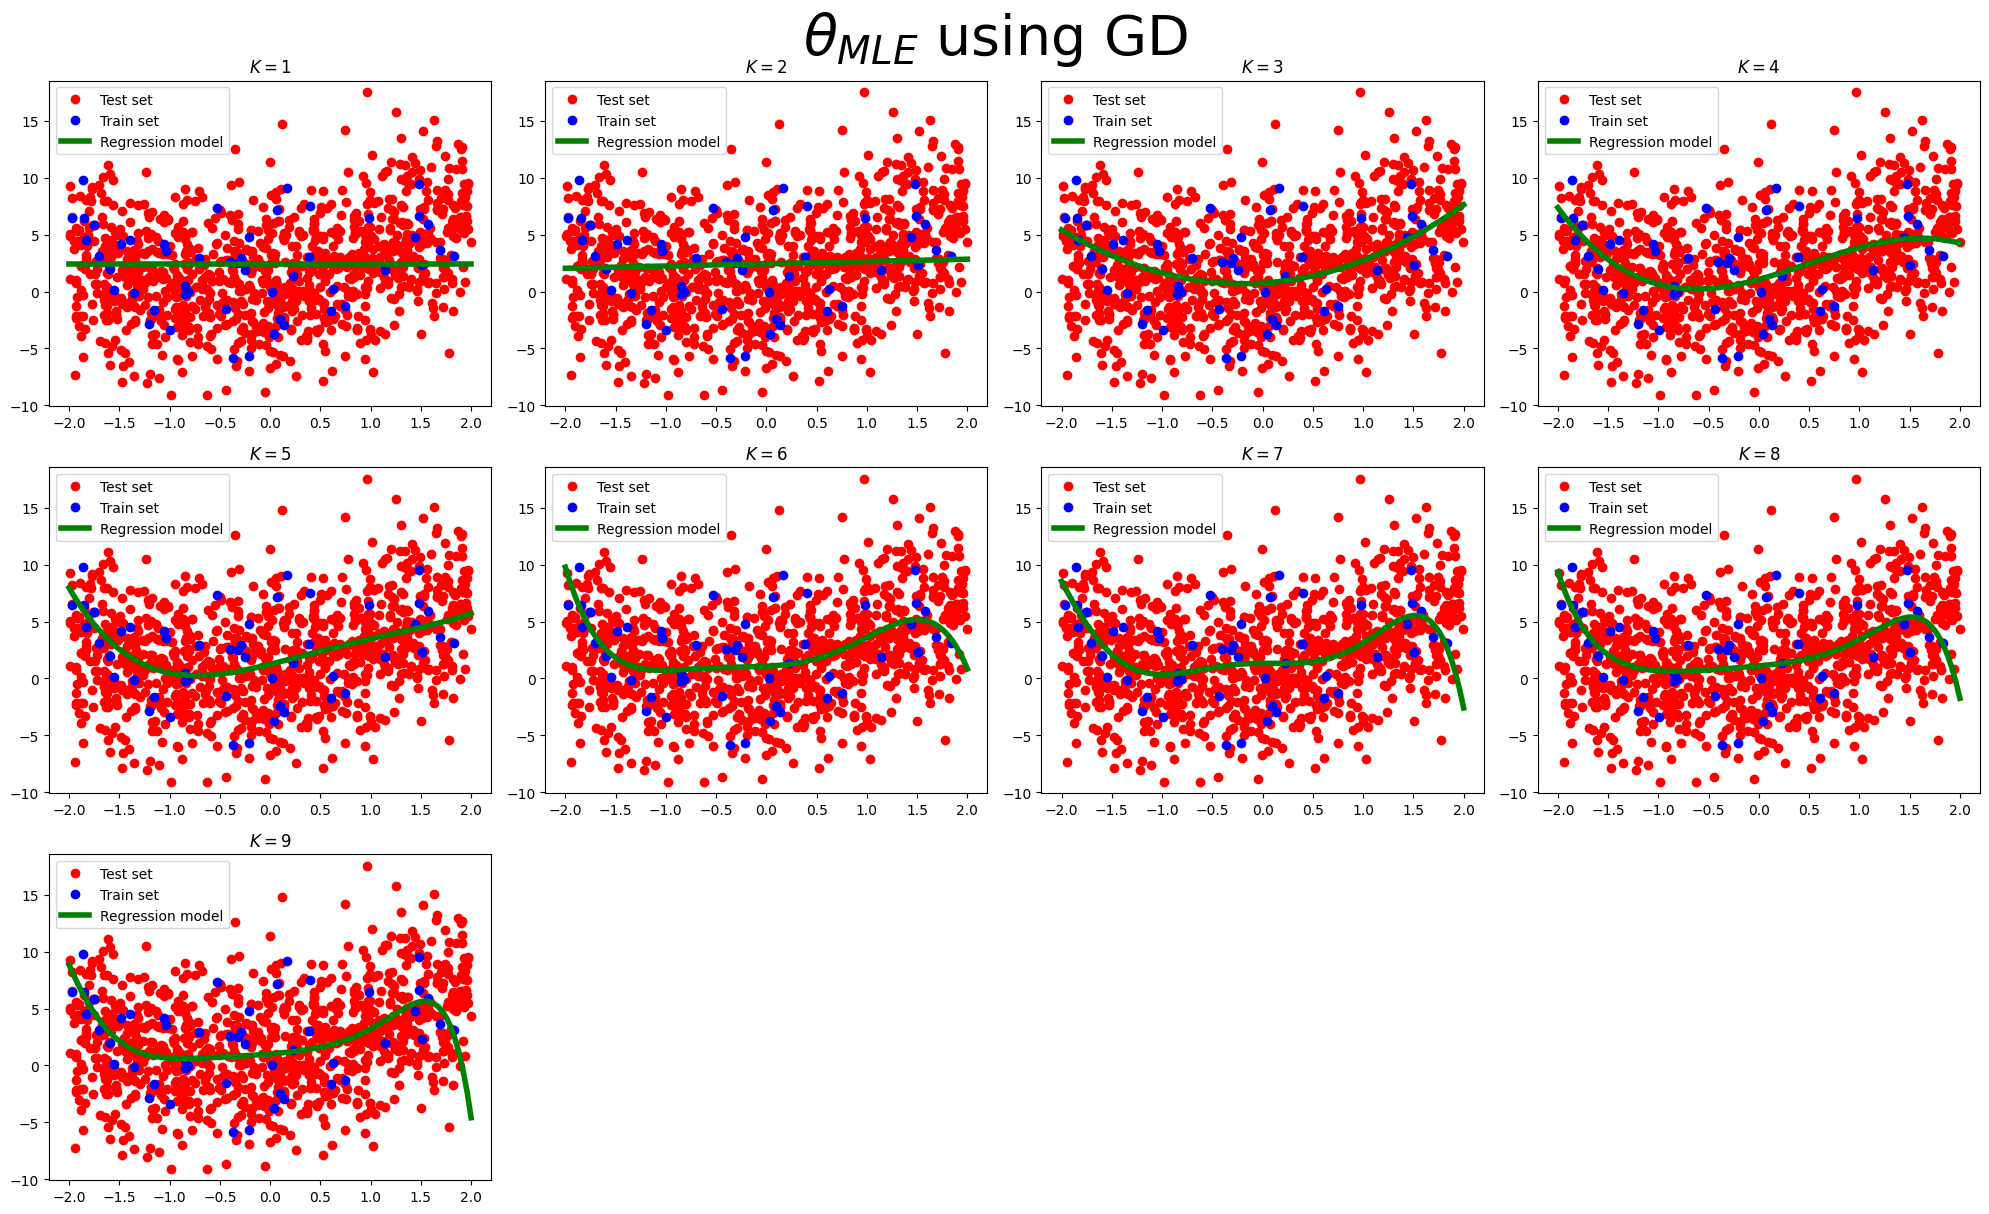

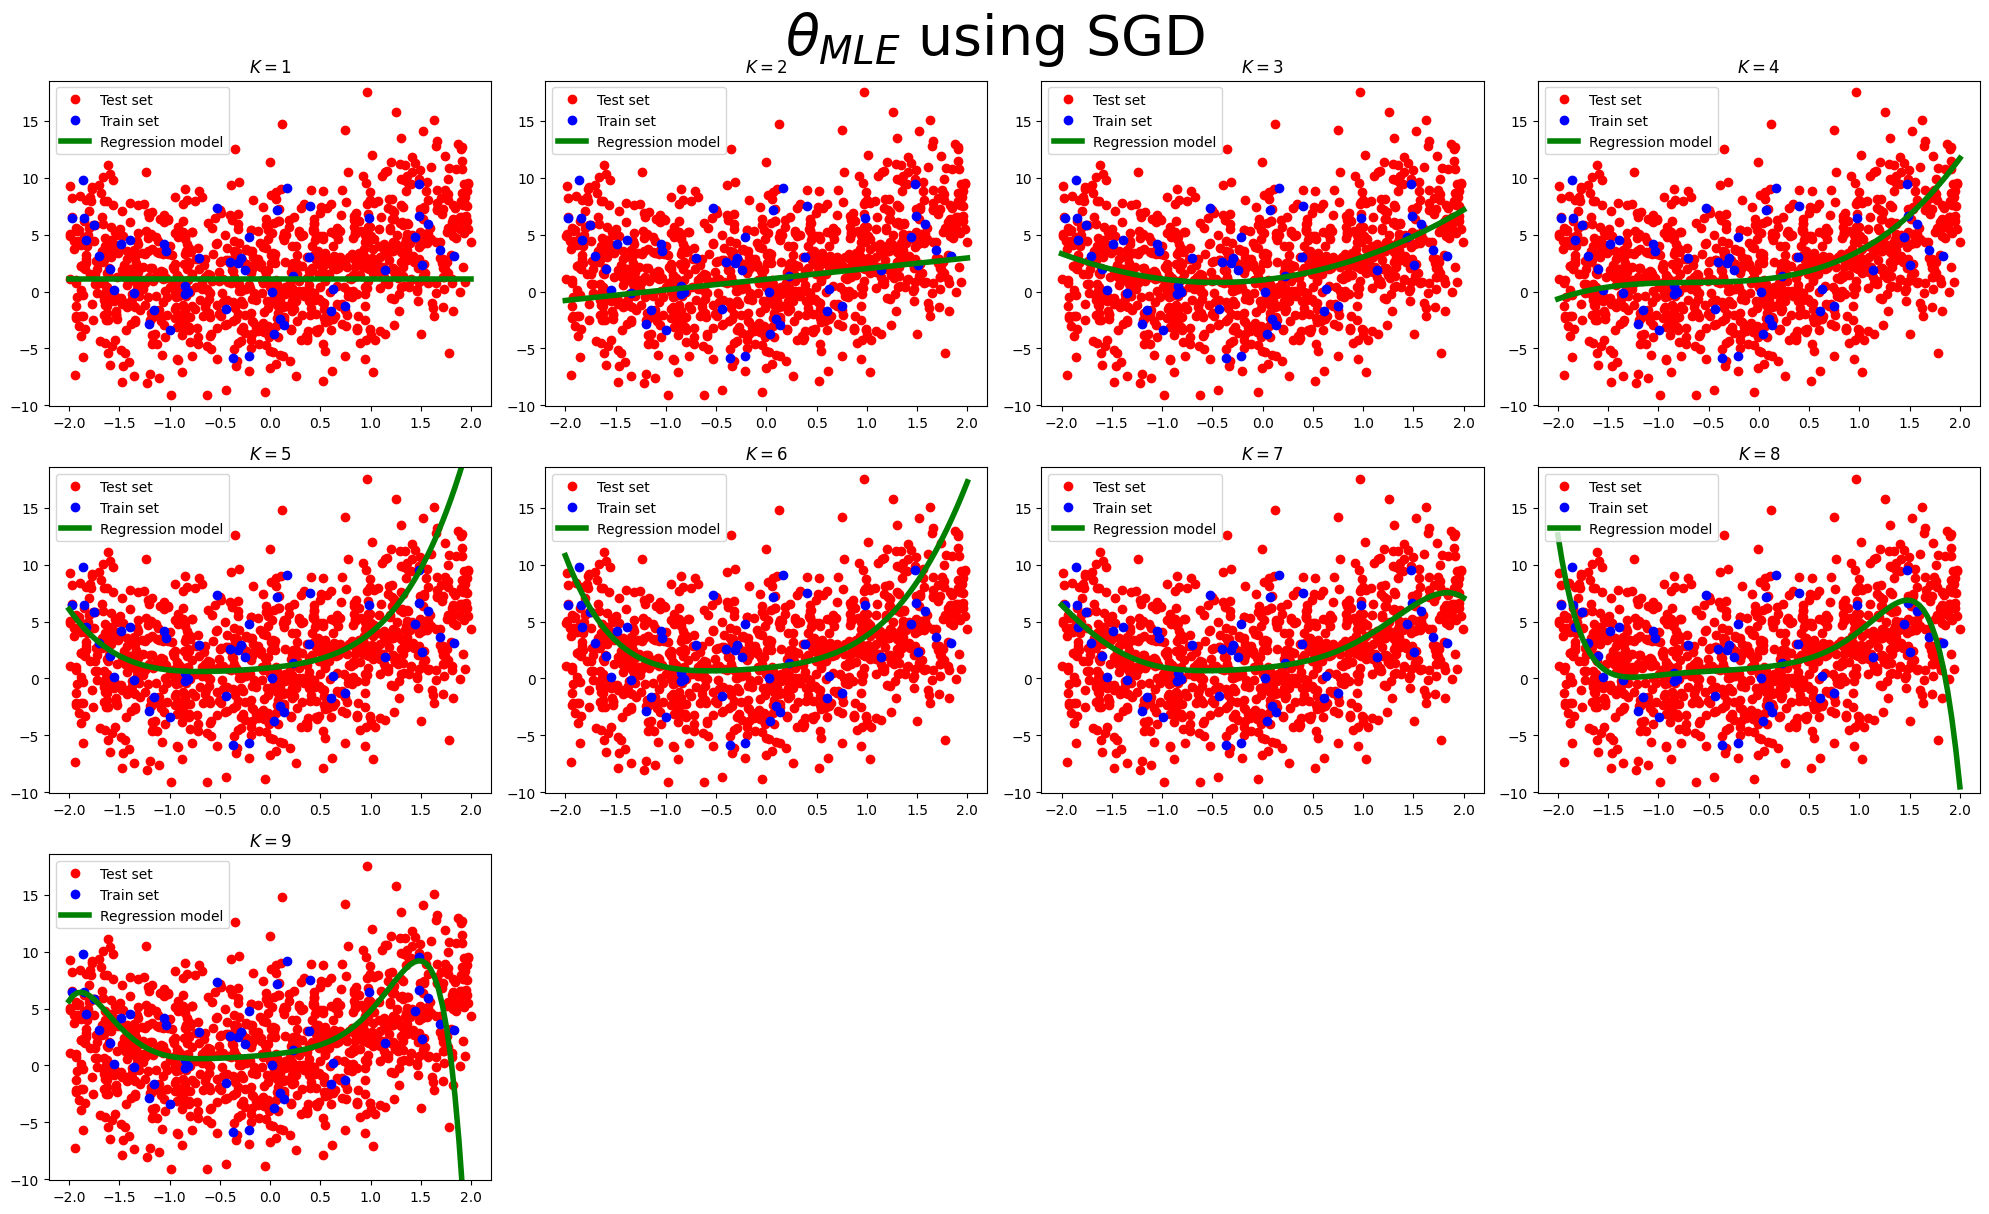

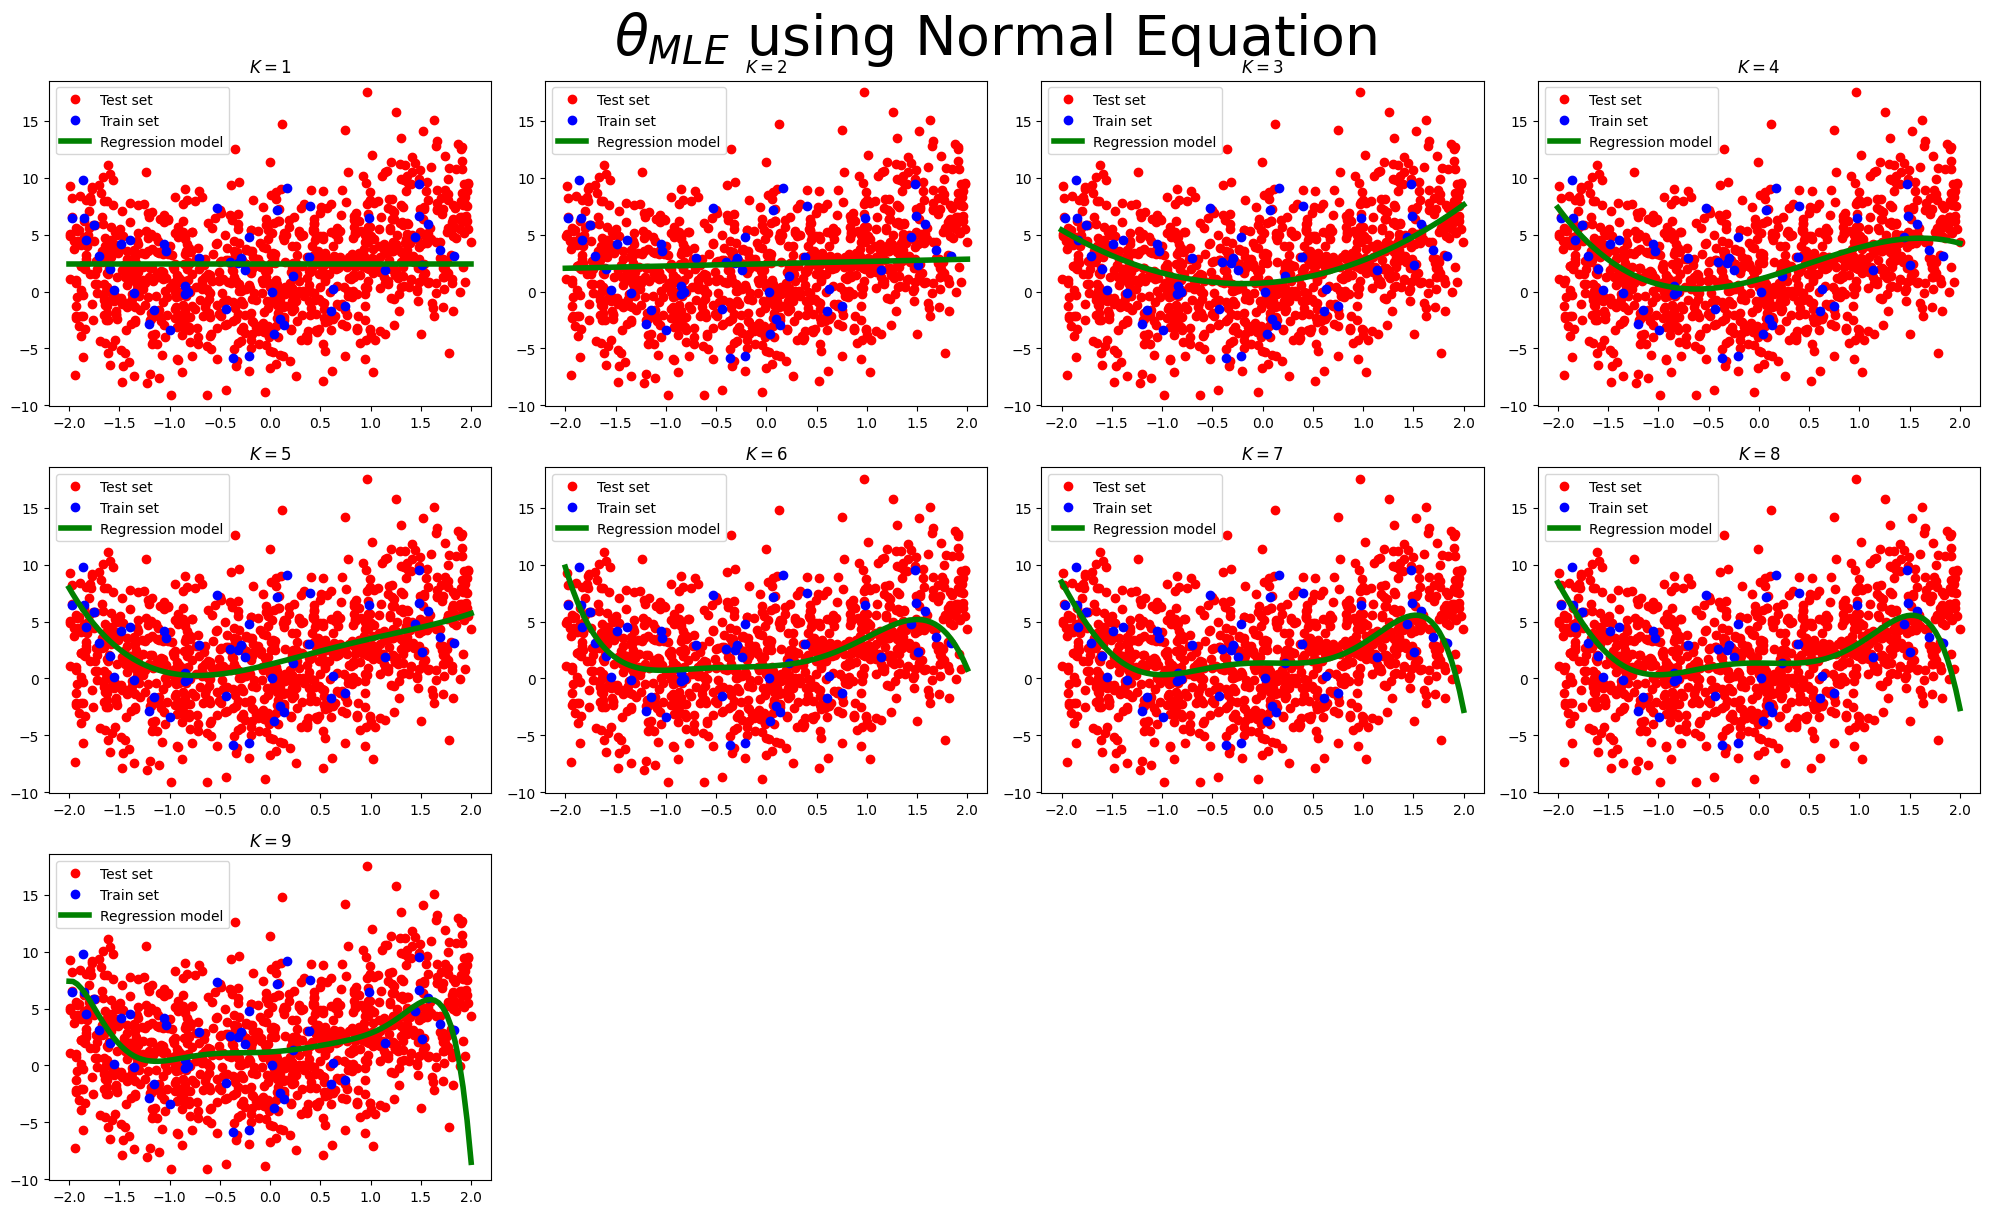

In [25]:
## X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.90,random_state=random_state)
X_train, y_train = X,Y
N_test = 1000
X_test = np.random.uniform(low=a, high=b, size=(N_test,))
Phi_X = np.flip(np.vander(X_test,K), 1)
y_test = Phi_X @ theta_true + np.random.normal(0, sigma**2,(N_test,))

kk = range(1,10)
# MLE using GD
thetas_GD_MLE, kk_GD_MLE = optimize((X_train,y_train), 'GD', loss=loss_MLE, grad_loss=grad_loss_MLE, kk=kk, approach='MLE', kmax=5000)
plot_thetas(kk_GD_MLE, thetas_GD_MLE, (X_train, y_train), (X_test, y_test), a,b , f, title="$\\theta_{MLE}$ using GD")
# MLE using SGD
thetas_SGD_MLE, kk_SGD_MLE = optimize((X_train,y_train), 'SGD', loss=loss_MLE, grad_loss=grad_loss_MLE, kk=kk, approach='MLE', n_epochs=10000, batch_size=100, alpha=10e-8)
plot_thetas(kk_SGD_MLE, thetas_SGD_MLE, (X_train, y_train), (X_test, y_test), a,b , f, title="$\\theta_{MLE}$ using SGD")
# MLE using Normnal Equation
thetas_Normal_MLE, kk_Normal_MLE = optimize((X_train,y_train), 'Normal', kk=kk, approach='MLE')
plot_thetas(kk_Normal_MLE, thetas_Normal_MLE, (X_train, y_train), (X_test, y_test), a,b , f, title="$\\theta_{MLE}$ using Normal Equation")

**From the graphs above it's very clear that using the Normal Equation is the best way of solving for $\theta_{MLE}$, confronting GD and SGD we see that GD being more accurate gives better approximations but it's more computational expensive.**

**Both GD and SGD tends to overfits on the training data with higher values for k particularly near the border of $[a,b]$.**

###  [&#8593;](#toc0_) <a id='toc5_1_2_'></a>Test and train error

-   - For increasing values of $K$, use the functions defined above to compute the training and test error, where the test set is generated by sampling $N_{test}$ new points on the same interval $[a, b]$ of the training set and generating the corresponding $Y_{test}$ with the same procedure of the training set. Plot the two errors with respect to $K$. Comment the results.

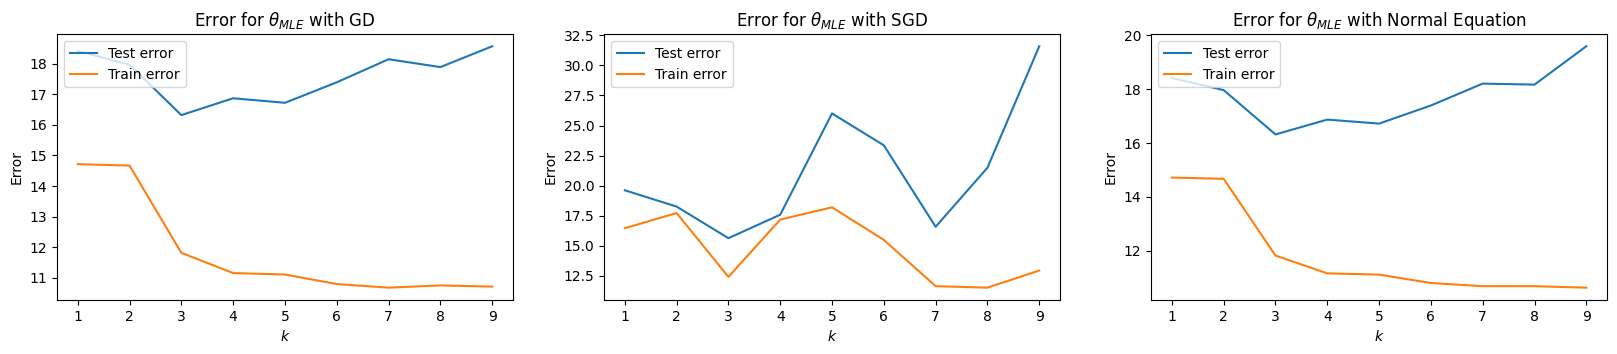

In [26]:
test_errors_GD_MLE, train_errors_GD_MLE, test_errors_SGD_MLE, train_errors_SGD_MLE, test_errors_Normal_MLE, train_errors_Normal_MLE = [],[],[],[],[],[]

for i,k in enumerate(kk_GD_MLE):
    test_errors_GD_MLE.append(evaluate(theta=thetas_GD_MLE[i], test_set=(X_test, y_test)))
    train_errors_GD_MLE.append(evaluate(theta=thetas_GD_MLE[i], test_set=(X_train, y_train )))

for i,k in enumerate(kk_SGD_MLE):
    test_errors_SGD_MLE.append(evaluate(theta=thetas_SGD_MLE[i], test_set=(X_test, y_test)))
    train_errors_SGD_MLE.append(evaluate(theta=thetas_SGD_MLE[i], test_set=(X_train, y_train )))

for i,k in enumerate(kk_Normal_MLE):
    test_errors_Normal_MLE.append(evaluate(theta=thetas_Normal_MLE[i], test_set=(X_test, y_test)))
    train_errors_Normal_MLE.append(evaluate(theta=thetas_Normal_MLE[i], test_set=(X_train, y_train )))

plot_errors(kk = [kk_GD_MLE, kk_SGD_MLE, kk_Normal_MLE],
            train_errors=[train_errors_GD_MLE, train_errors_SGD_MLE, train_errors_Normal_MLE],
            test_errors=[test_errors_GD_MLE, test_errors_SGD_MLE, test_errors_Normal_MLE],
            title=['Error for $\\theta_{MLE}$ with GD', 'Error for $\\theta_{MLE}$ with SGD','Error for $\\theta_{MLE}$ with Normal Equation'])

**GD and SGD don't performs very well, and it's clear that when $k>3$ we see little to no improvement and we see a starting point for overfitting.**

##  [&#8593;](#toc0_) <a id='toc5_2_'></a>MAP

###  [&#8593;](#toc0_) <a id='toc5_2_1_'></a>Regression Model

-  - Write a function that takes as input the training data $\mathbb{D} = (X, Y ), K$ and $\lambda > 0$ and returns the MAP solution (with Gaussian assumption) $\theta_{MAP} \in \mathbb{R}^K$ for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations.
   - For $K$ lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model $f_{\theta_{MAP}}(x)$ with different values of $\lambda$. Comment the results.

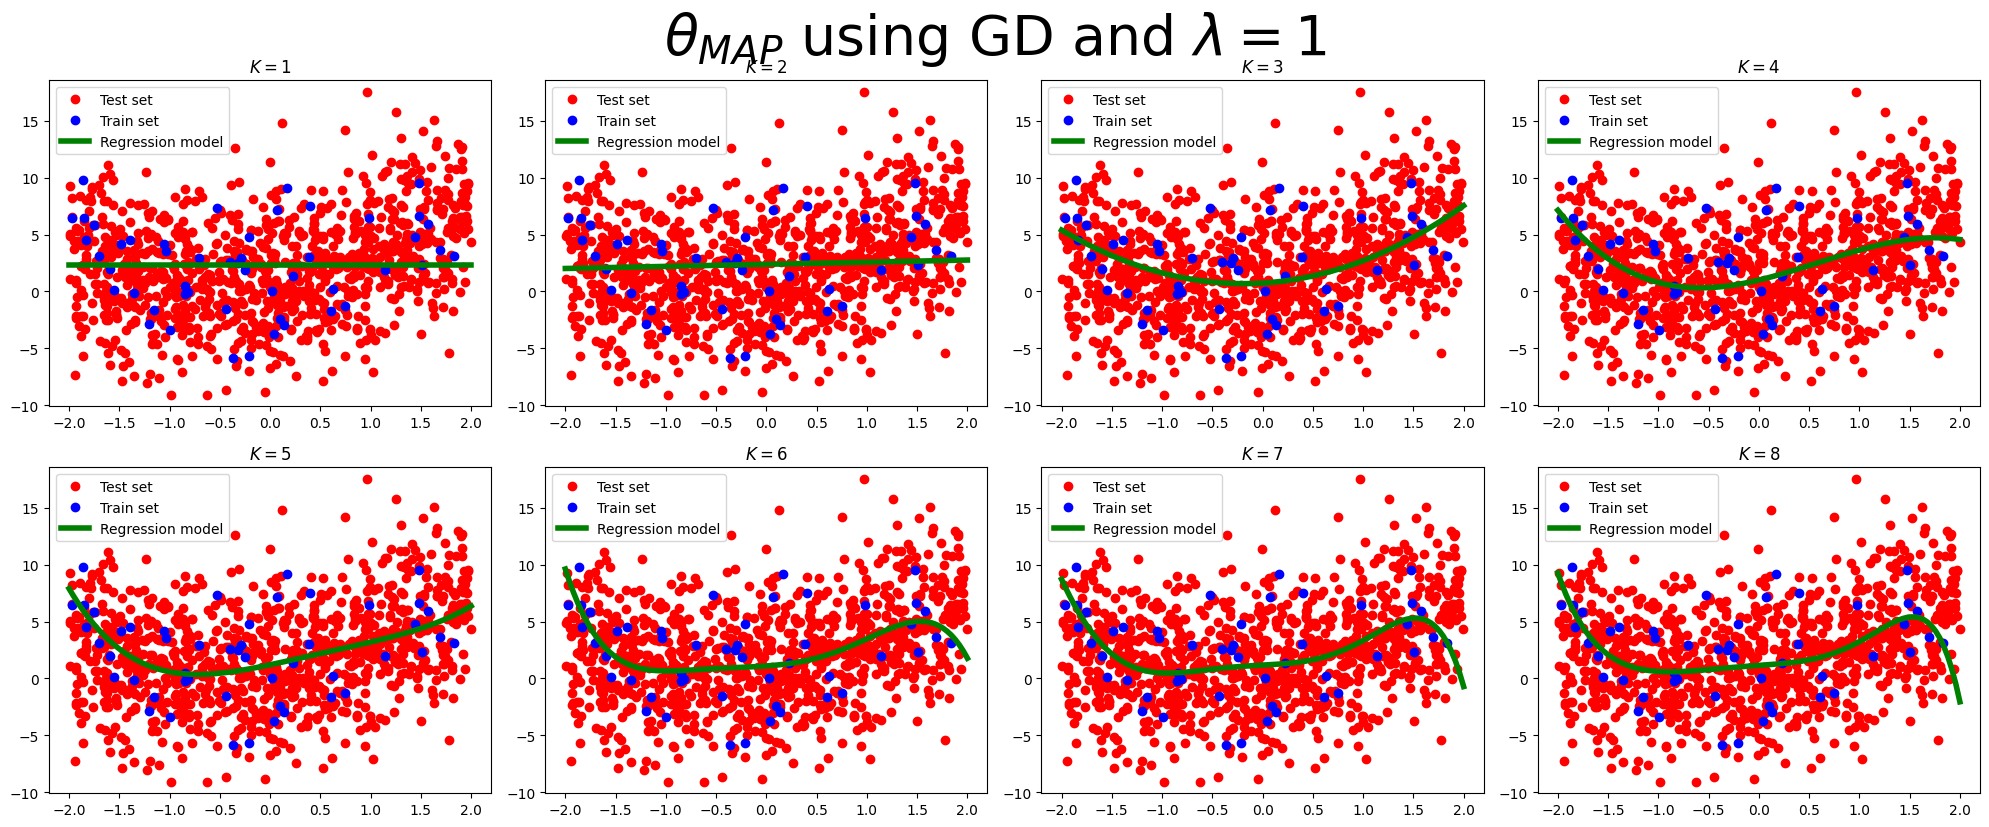

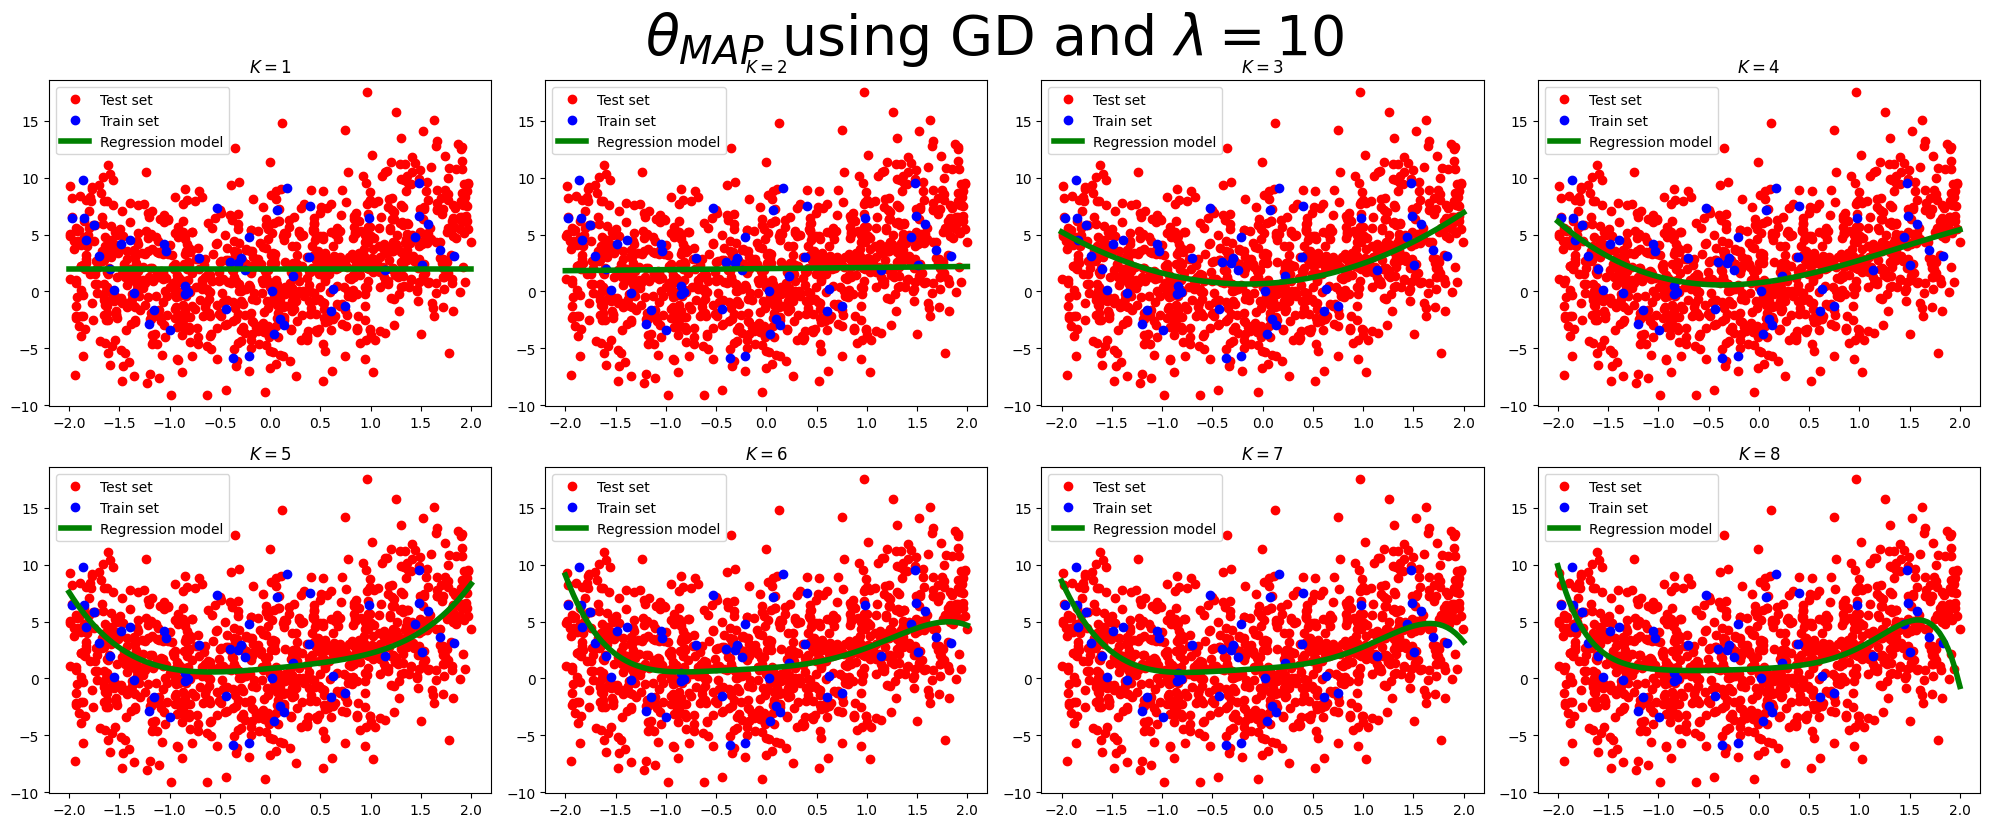

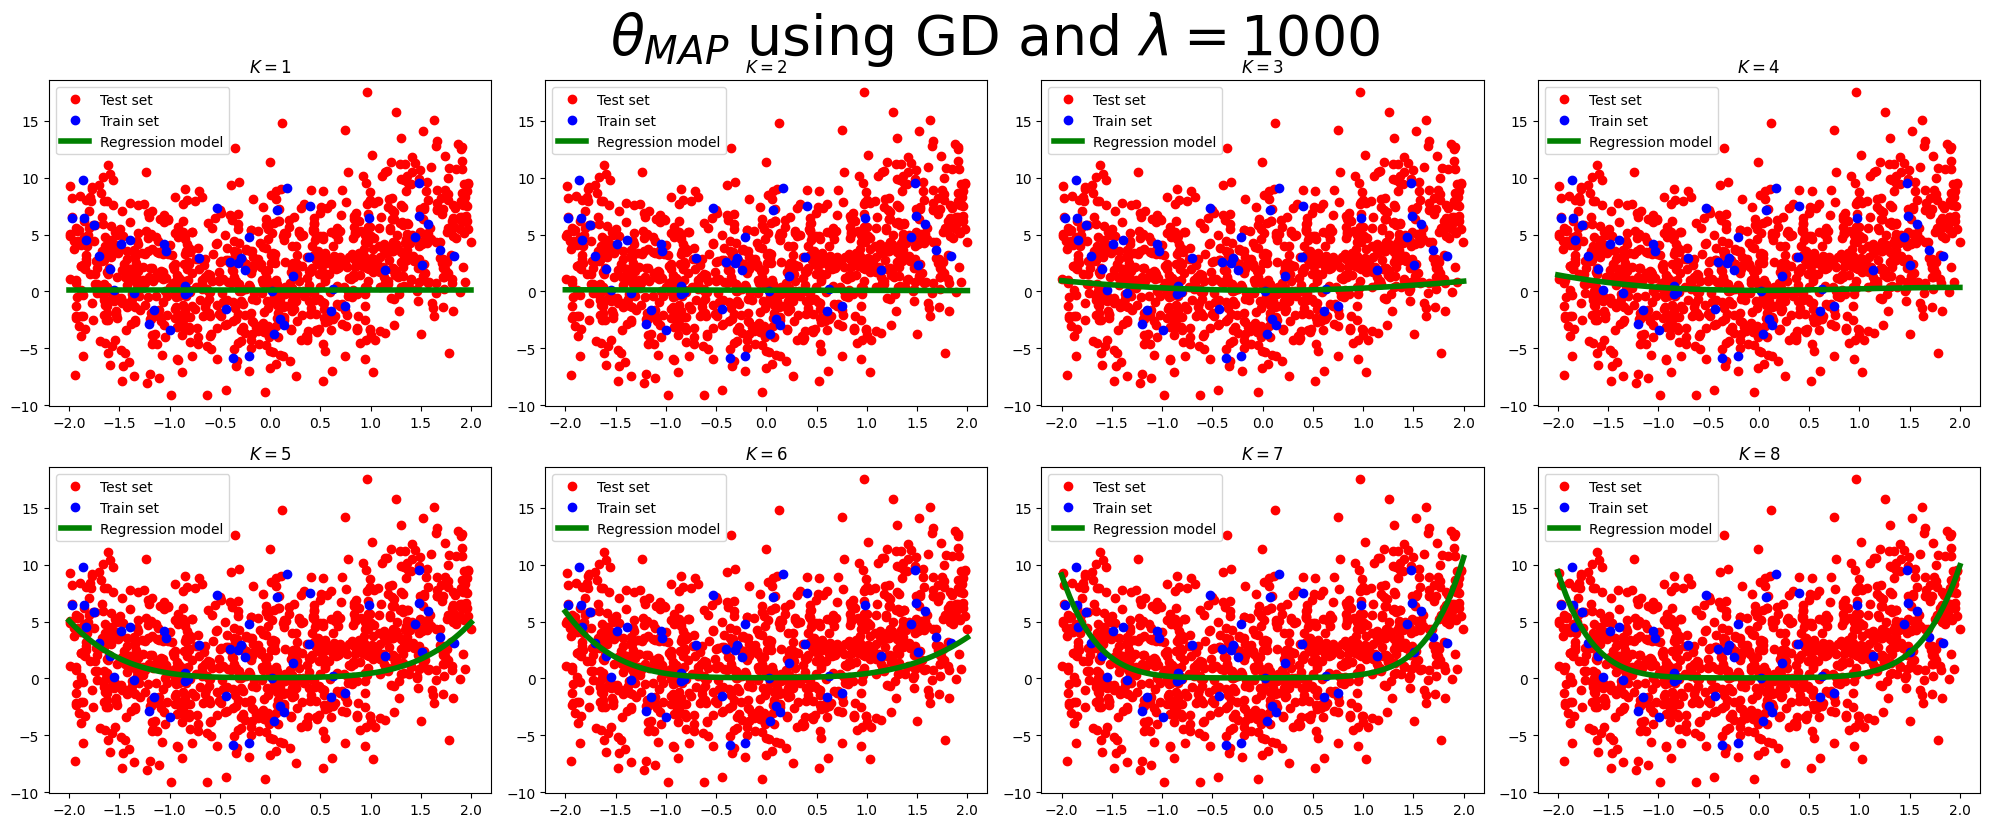

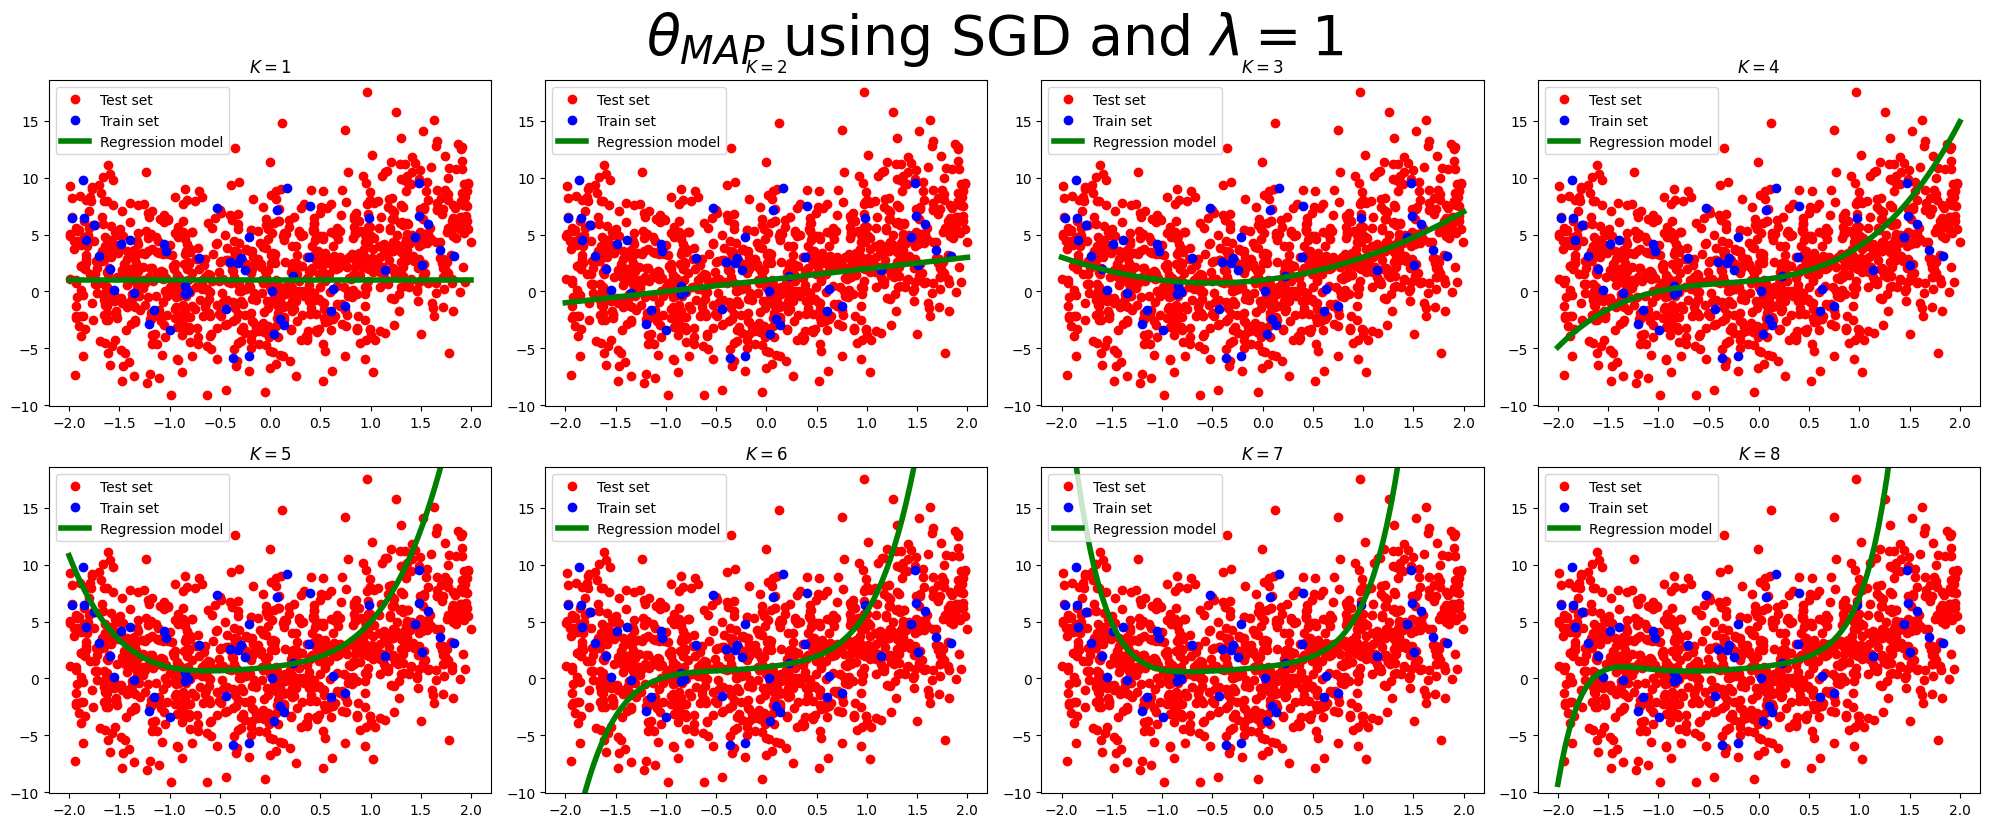

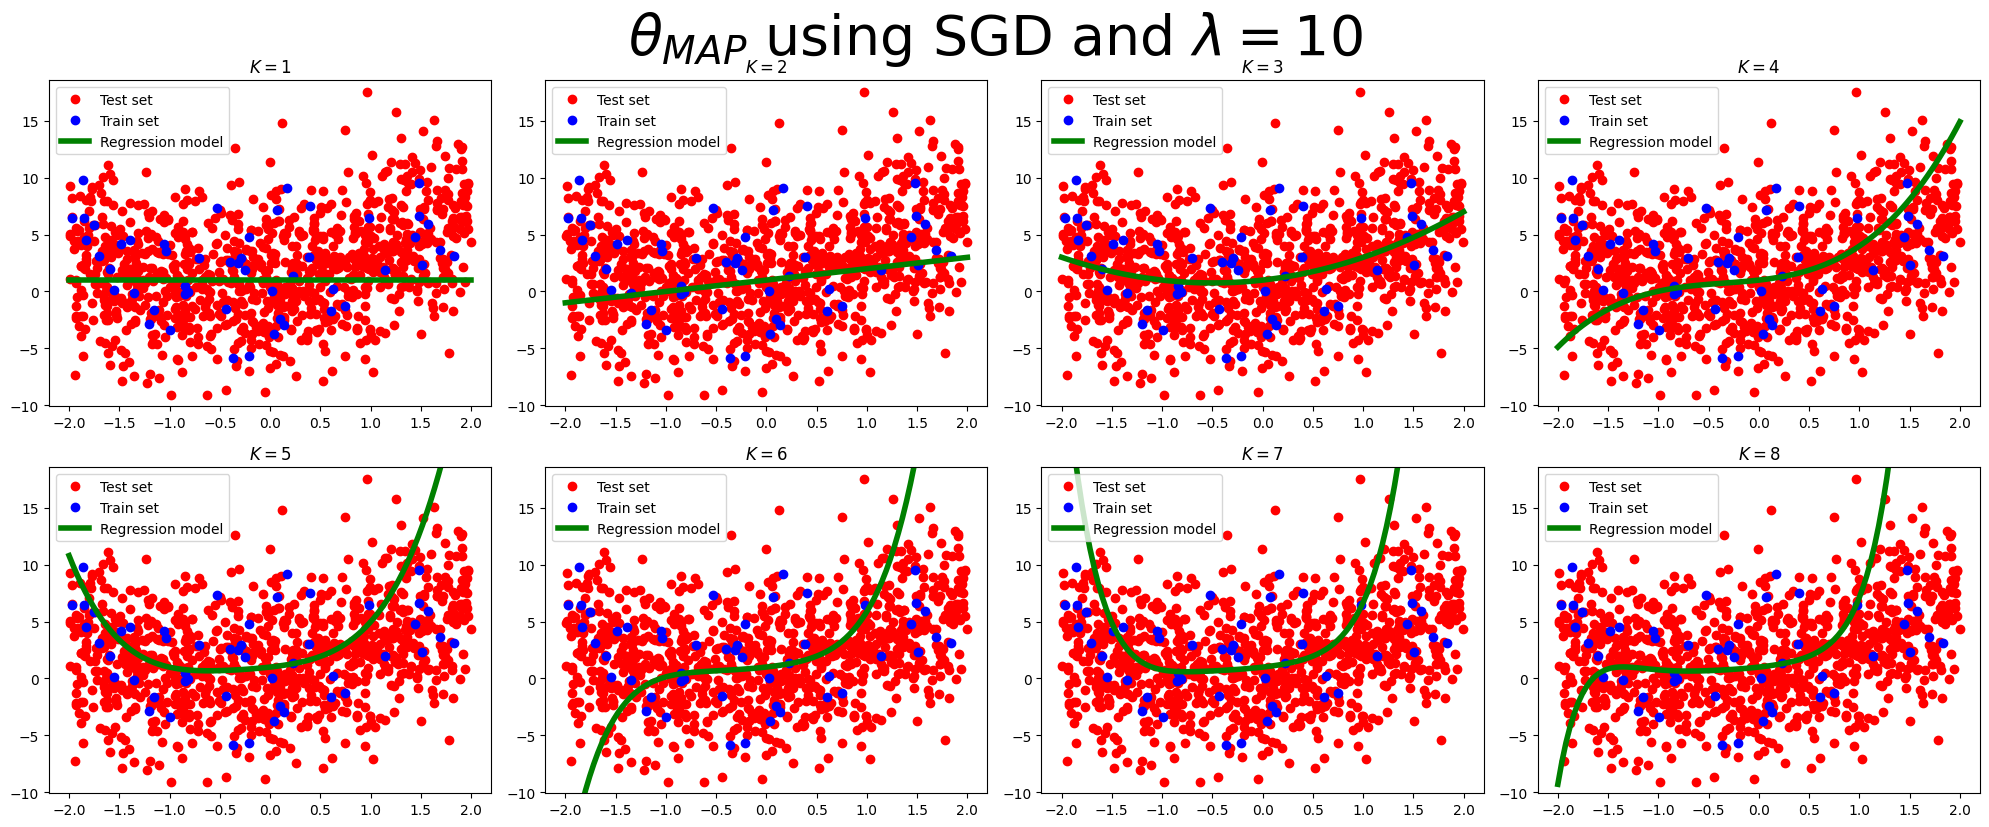

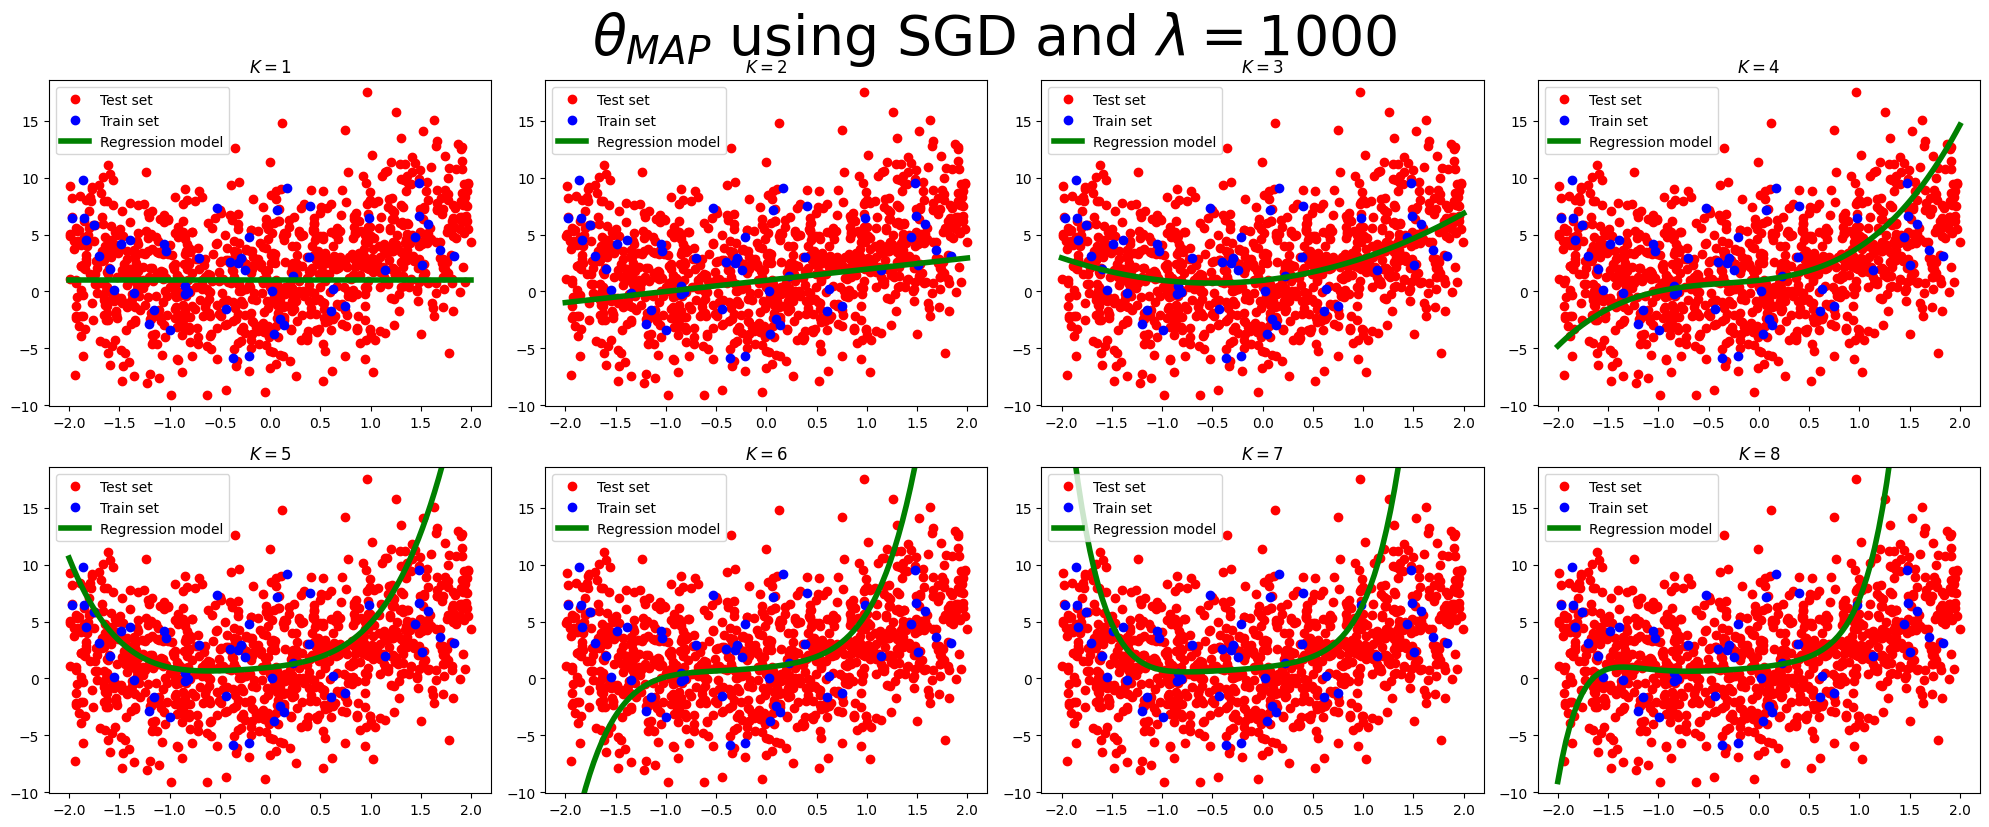

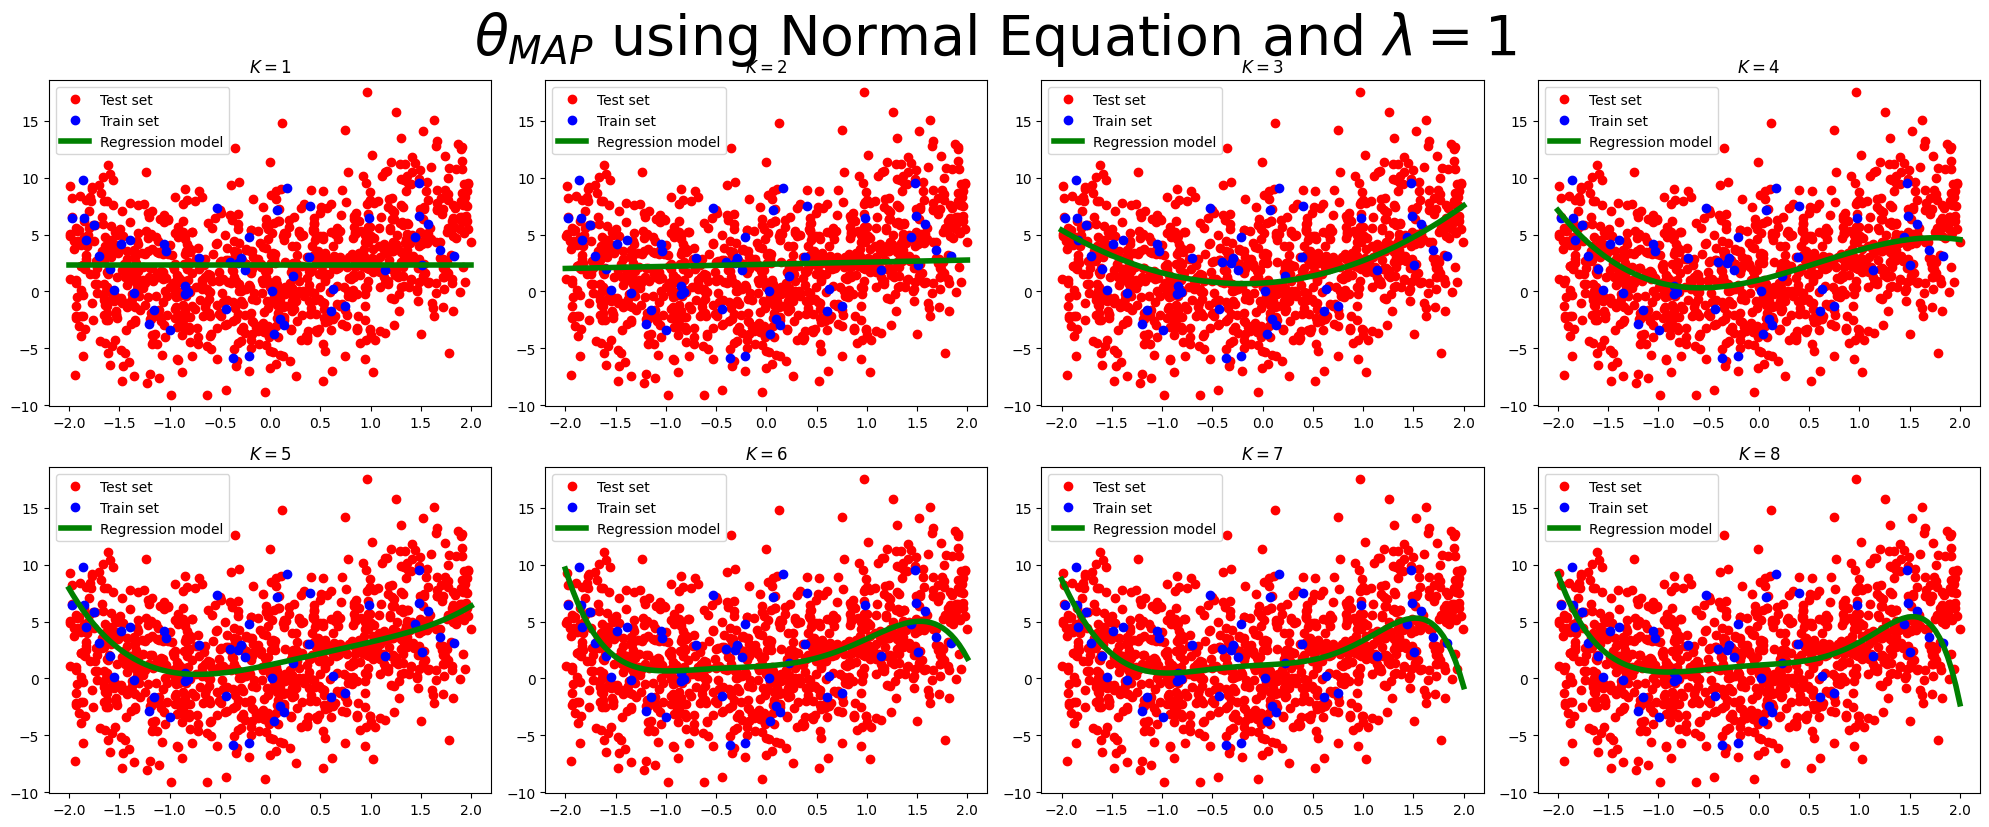

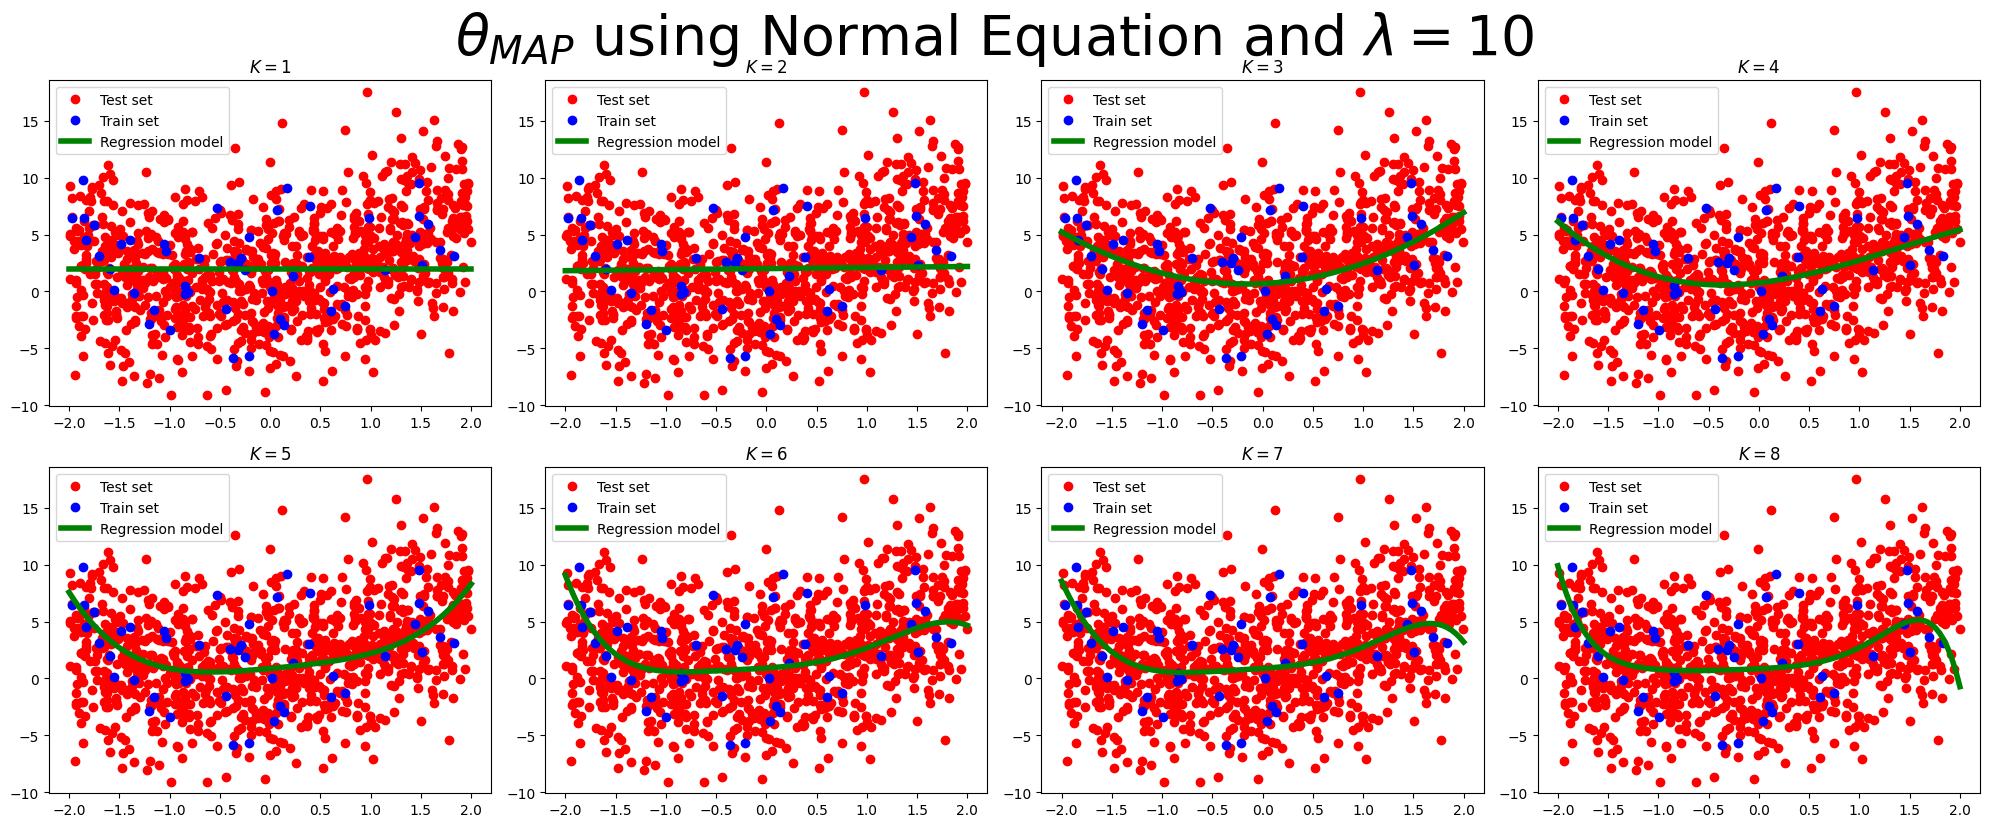

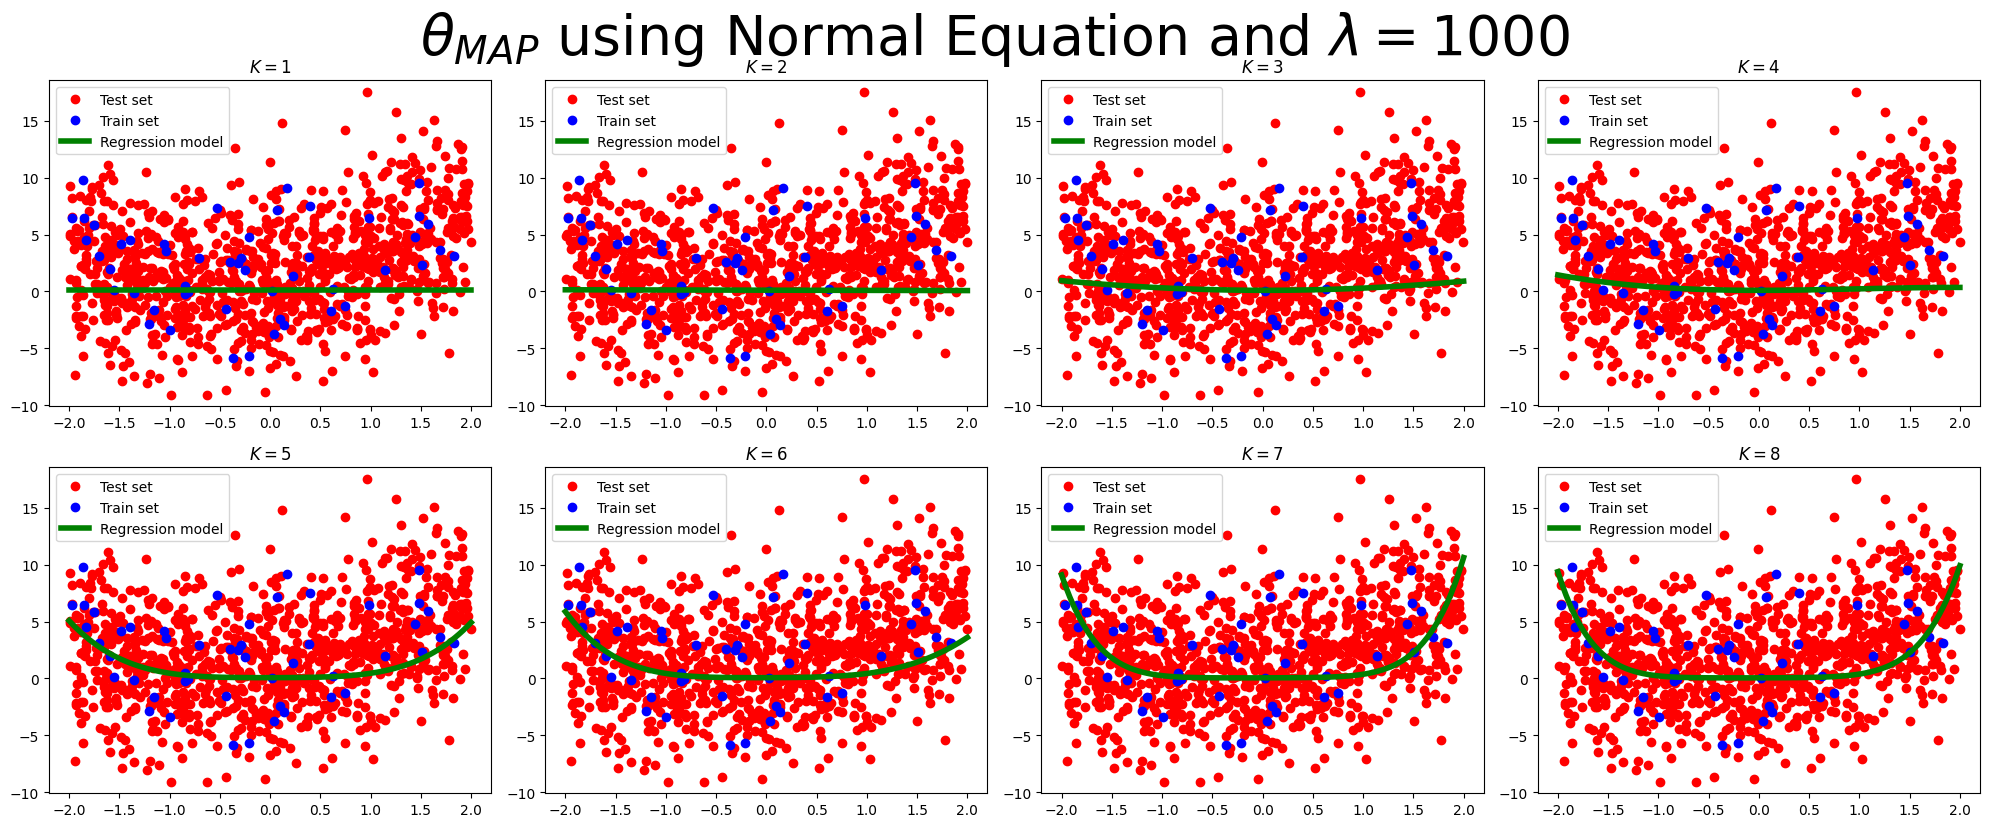

In [27]:
kk = range(1,9)
lambdas = [1,10,1000]
thetas_GD_MAP_lam, kk_GD_MAP_lam, thetas_SGD_MAP_lam, kk_SGD_MAP_lam, thetas_Normal_MAP_lam, kk_Normal_MAP_lam = [],[], [], [], [], []

# MAP using GD
for lam in lambdas:
    thetas_GD_MAP, kk_GD_MAP = optimize((X_train,y_train), 'GD', loss=loss_MAP, grad_loss=grad_loss_MAP, kk=kk, approach='MAP', kmax=20000, lam=lam)
    thetas_GD_MAP_lam.append(thetas_GD_MAP)
    kk_GD_MAP_lam.append(kk_GD_MAP)
    plot_thetas(kk_GD_MAP, thetas_GD_MAP, (X_train, y_train), (X_test, y_test), a,b , f, title=f"$\\theta_{{MAP}}$ using GD and $\\lambda={lam}$")
# MAP using SGD
for lam in lambdas:
    thetas_SGD_MAP, kk_SGD_MAP = optimize((X_train,y_train), 'SGD', loss=loss_MAP, grad_loss=grad_loss_MAP, kk=kk, approach='MAP', n_epochs=20000, batch_size=1000, alpha=10e-10, lam=lam)
    thetas_SGD_MAP_lam.append(thetas_SGD_MAP)
    kk_SGD_MAP_lam.append(kk_SGD_MAP)
    plot_thetas(kk_SGD_MAP, thetas_SGD_MAP, (X_train, y_train), (X_test, y_test), a,b , f, title=f"$\\theta_{{MAP}}$ using SGD and $\\lambda={lam}$")
# MAP using Normnal Equation
for lam in lambdas:
    thetas_Normal_MAP, kk_Normal_MAP = optimize((X_train,y_train), 'Normal', kk=kk, approach='MAP', lam=lam)
    thetas_Normal_MAP_lam.append(thetas_Normal_MAP)
    kk_Normal_MAP_lam.append(kk_Normal_MAP)
    plot_thetas(kk_Normal_MAP, thetas_Normal_MAP, (X_train, y_train), (X_test, y_test), a,b , f, title=f"$\\theta_{{MAP}}$ using Normal Equation and $\\lambda={lam}$")

**As in the previous cases the most precise method is the Normal Equation and after that the GD.**

**Visually the $\lambda$ value don't change the regression model too much, but as we see in the code after this one, it can help reducing the error of $\theta$.**

### Test and train error with different values for $\lambda$

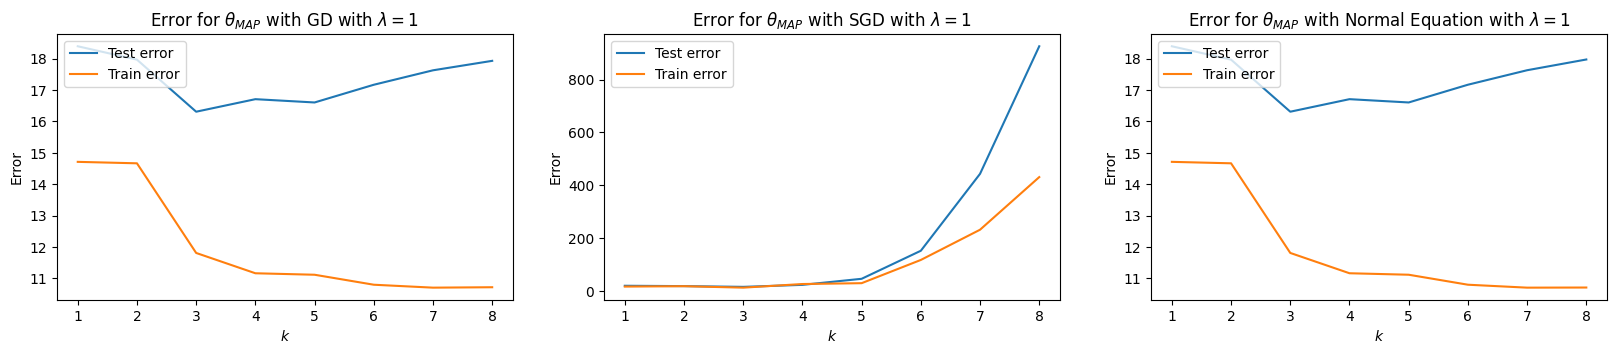

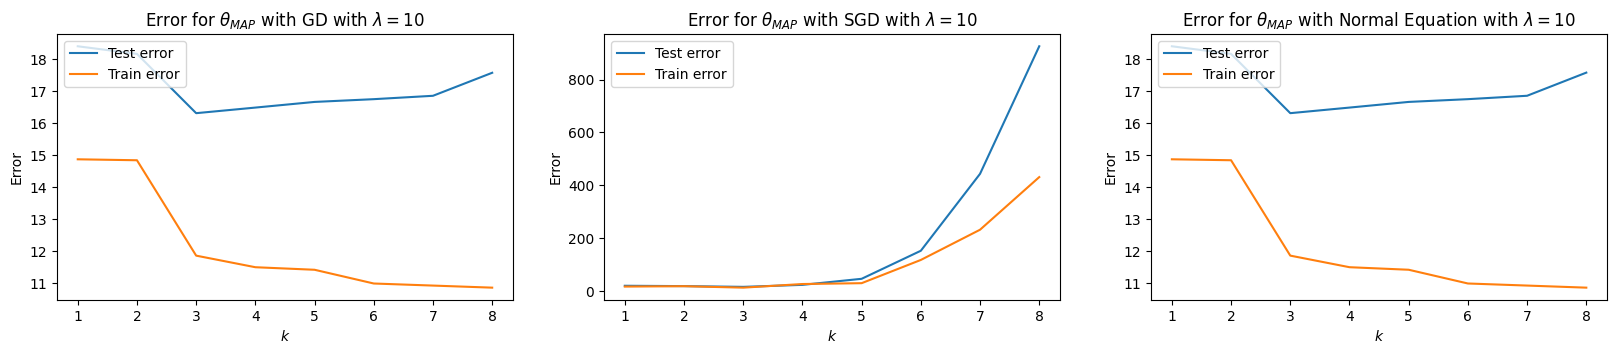

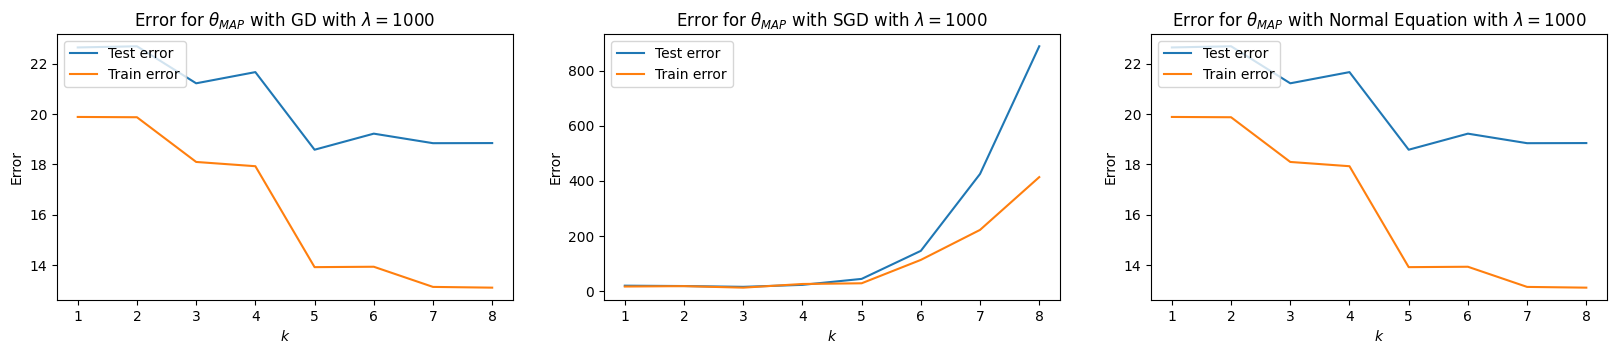

In [28]:

for j,lam in enumerate(lambdas):
    test_errors_GD_MAP, train_errors_GD_MAP, test_errors_SGD_MAP, train_errors_SGD_MAP, test_errors_Normal_MAP, train_errors_Normal_MAP = [],[],[],[],[],[]

    for i,k in enumerate(kk_GD_MAP):
        test_errors_GD_MAP.append(evaluate(theta=thetas_GD_MAP_lam[j][i], test_set=(X_test, y_test)))
        train_errors_GD_MAP.append(evaluate(theta=thetas_GD_MAP_lam[j][i], test_set=(X_train, y_train )))

    for i,k in enumerate(kk_SGD_MAP):
        test_errors_SGD_MAP.append(evaluate(theta=thetas_SGD_MAP_lam[j][i], test_set=(X_test, y_test)))
        train_errors_SGD_MAP.append(evaluate(theta=thetas_SGD_MAP_lam[j][i], test_set=(X_train, y_train )))

    for i,k in enumerate(kk_Normal_MAP):
        test_errors_Normal_MAP.append(evaluate(theta=thetas_Normal_MAP_lam[j][i], test_set=(X_test, y_test)))
        train_errors_Normal_MAP.append(evaluate(theta=thetas_Normal_MAP_lam[j][i], test_set=(X_train, y_train )))

    plot_errors(kk = [kk_GD_MAP, kk_SGD_MAP, kk_Normal_MAP],
                train_errors=[train_errors_GD_MAP, train_errors_SGD_MAP, train_errors_Normal_MAP],
                test_errors=[test_errors_GD_MAP, test_errors_SGD_MAP, test_errors_Normal_MAP],
                title=[f'Error for $\\theta_{{MAP}}$ with GD with $\\lambda = {lam}$', f'Error for $\\theta_{{MAP}}$ with SGD with $\\lambda = {lam}$',f'Error for $\\theta_{{MAP}}$ with Normal Equation with $\\lambda = {lam}$'])

##  [&#8593;](#toc0_) <a id='toc5_3_'></a>MLE vs MAP

-   - For $K$ being way greater than the correct degree of the polynomial, compute the MLE and MAP solution. Compare the test error of the two, for different values of $\lambda$ (in the case of MAP).

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.67,random_state=random_state)
kk = [5,6,7,8,9,10,15,20]
lambdas = [1,10,1000]
thetas_GD_MAP_lam, kk_GD_MAP_lam,thetas_SGD_MAP_lam, kk_SGD_MAP_lam,thetas_Normal_MAP_lam, kk_Normal_MAP_lam = [],[],[],[],[],[]
# MAP using GD
for lam in lambdas:
    thetas_GD_MAP, kk_GD_MAP = optimize((X_train,y_train), 'GD', loss=loss_MAP, grad_loss=grad_loss_MAP, kk=kk, approach='MAP', kmax=20000, lam=lam)
    thetas_GD_MAP_lam.append(thetas_GD_MAP)
    kk_GD_MAP_lam.append(kk_GD_MAP)
# MAP using SGD
for lam in lambdas:
    thetas_SGD_MAP, kk_SGD_MAP = optimize((X_train,y_train), 'SGD', loss=loss_MAP, grad_loss=grad_loss_MAP, kk=kk, approach='MAP', n_epochs=20000, batch_size=1000, alpha=10e-8, lam=lam)
    thetas_SGD_MAP_lam.append(thetas_SGD_MAP)
    kk_SGD_MAP_lam.append(kk_SGD_MAP)
# MAP using Normnal Equation
for lam in lambdas:
    thetas_Normal_MAP, kk_Normal_MAP = optimize((X_train,y_train), 'Normal', kk=kk, approach='MAP', lam=lam)
    thetas_Normal_MAP_lam.append(thetas_Normal_MAP)
    kk_Normal_MAP_lam.append(kk_Normal_MAP)
    
# MLE using GD
thetas_GD_MLE, kk_GD_MLE = optimize((X_train,y_train), 'GD', loss=loss_MLE, grad_loss=grad_loss_MLE, kk=kk, approach='MLE', kmax=20000)
# MLE using SGD
thetas_SGD_MLE, kk_SGD_MLE = optimize((X_train,y_train), 'SGD', loss=loss_MLE, grad_loss=grad_loss_MLE, kk=kk, approach='MLE', n_epochs=20000, batch_size=1000, alpha=10e-8)
# MLE using Normnal Equation
thetas_Normal_MLE, kk_Normal_MLE = optimize((X_train,y_train), 'Normal', kk=kk, approach='MLE')

###  [&#8593;](#toc0_) <a id='toc5_3_1_'></a>Test error

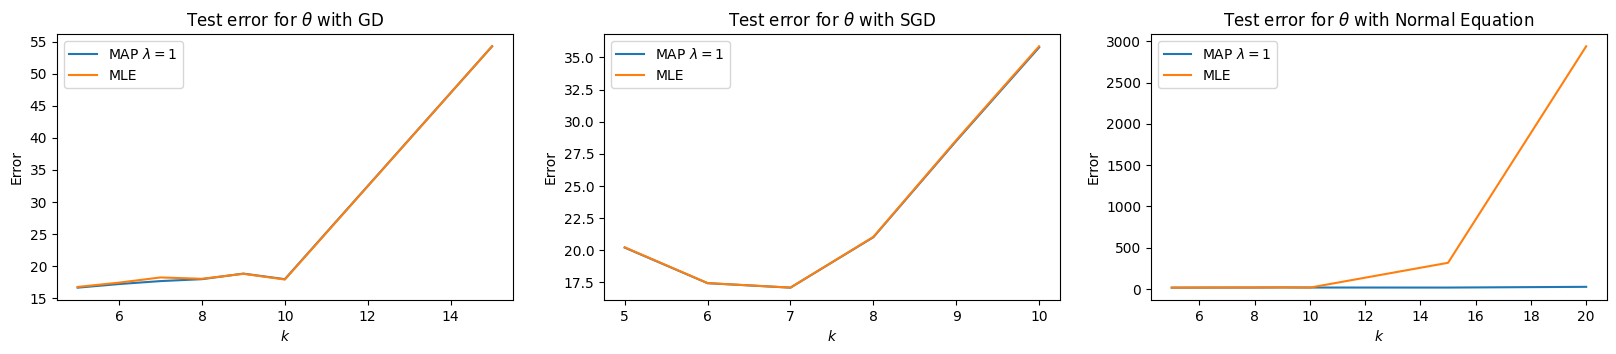

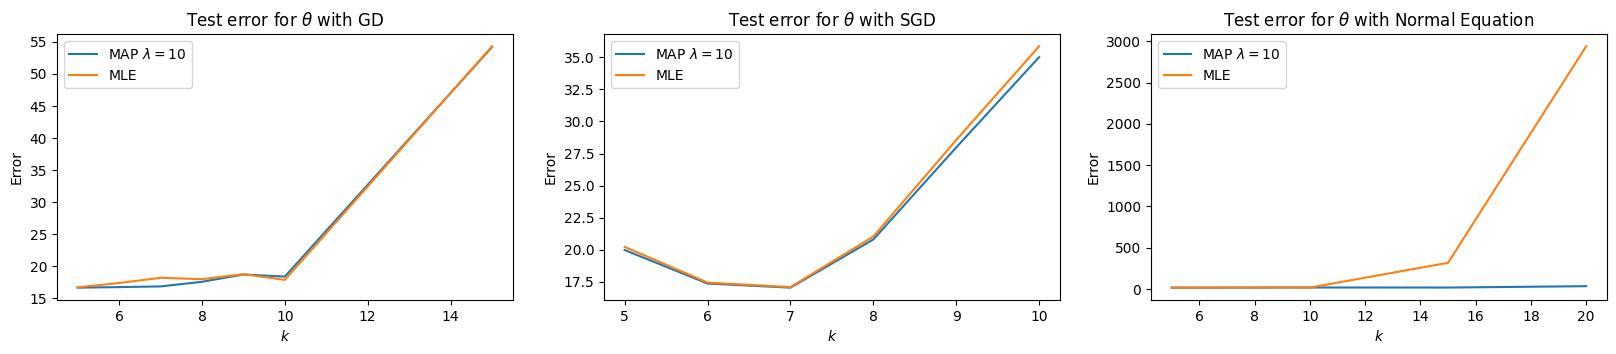

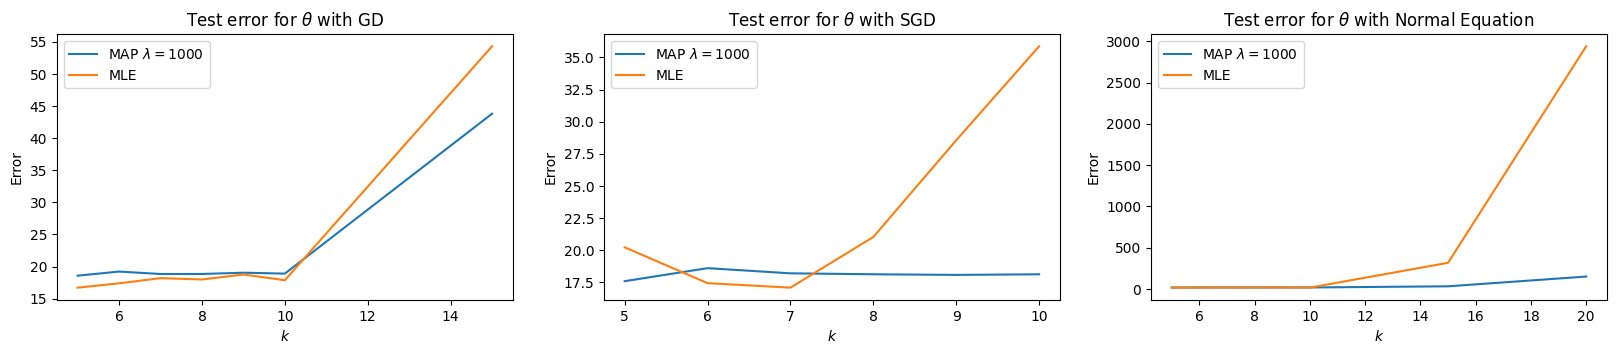

In [30]:
# Calculating test error for MAP with different lambdas
for j,lam in enumerate(lambdas):
    test_errors_GD_MAP, test_errors_SGD_MAP, test_errors_Normal_MAP = [],[],[]
    for i,k in enumerate(kk_GD_MAP):
        test_errors_GD_MAP.append(evaluate(theta=thetas_GD_MAP_lam[j][i], test_set=(X_test, y_test)))

    for i,k in enumerate(kk_SGD_MAP):
        test_errors_SGD_MAP.append(evaluate(theta=thetas_SGD_MAP_lam[j][i], test_set=(X_test, y_test)))

    for i,k in enumerate(kk_Normal_MAP):
        test_errors_Normal_MAP.append(evaluate(theta=thetas_Normal_MAP_lam[j][i], test_set=(X_test, y_test)))
    
    # Calculating test error for MLE
    test_errors_GD_MLE, test_errors_SGD_MLE, test_errors_Normal_MLE = [],[],[]
    for i,k in enumerate(kk_GD_MLE):
        test_errors_GD_MLE.append(evaluate(theta=thetas_GD_MLE[i], test_set=(X_test, y_test)))
    
    for i,k in enumerate(kk_SGD_MLE):
        test_errors_SGD_MLE.append(evaluate(theta=thetas_SGD_MLE[i], test_set=(X_test, y_test)))
        
    for i,k in enumerate(kk_Normal_MLE):
        test_errors_Normal_MLE.append(evaluate(theta=thetas_Normal_MLE[i], test_set=(X_test, y_test)))

        
    plot_errors(kk = [kk_GD_MAP, kk_SGD_MAP, kk_Normal_MAP],
                train_errors=[test_errors_GD_MLE, test_errors_SGD_MLE, test_errors_Normal_MLE],
                test_errors=[test_errors_GD_MAP, test_errors_SGD_MAP, test_errors_Normal_MAP],
                title=['Test error for $\\theta$ with GD', 'Test error for $\\theta$ with SGD','Test error for $\\theta$ with Normal Equation'],
                labels=['MLE', f'MAP $\\lambda={lam}$'])

###  [&#8593;](#toc0_) <a id='toc5_3_2_'></a>$Err(\theta)$
-   - For $K$ greater than the true degree of the polynomial, define $Err(\theta) = \frac{\| \theta-\theta_{true} \|_2}{ \| \theta_{true} \|_2}$ , where $\theta_{true}$ has been padded with zeros to match the shape of $\theta$. Compute $Err(\theta_{MLE})$ and $Err(\theta_{MAP})$ for increasing values of $K$ and different values of $\lambda$.

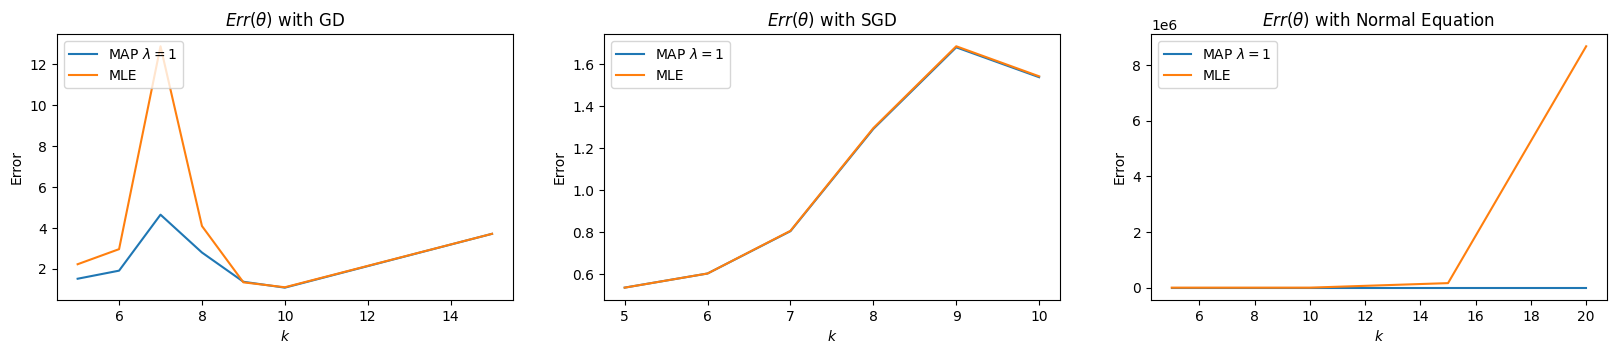

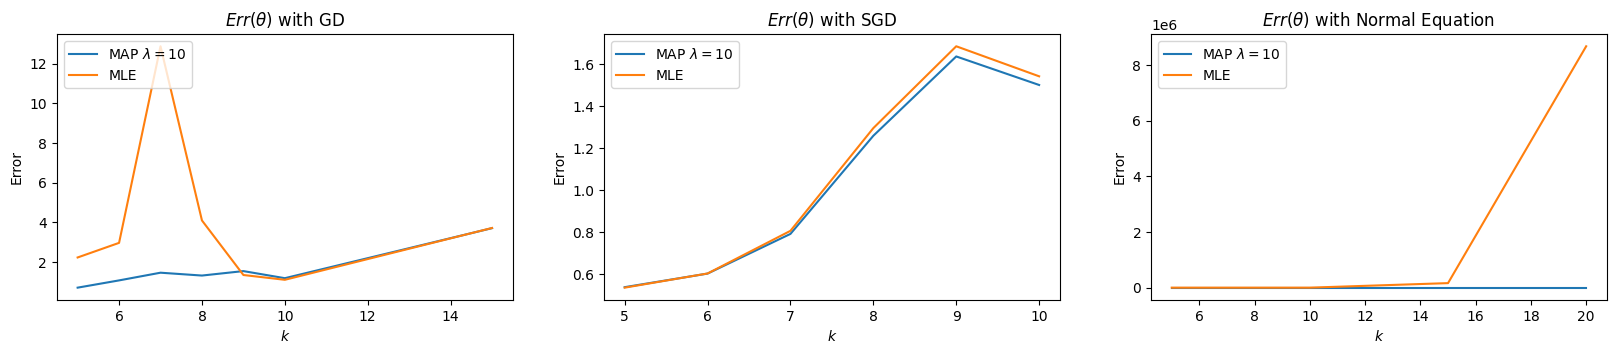

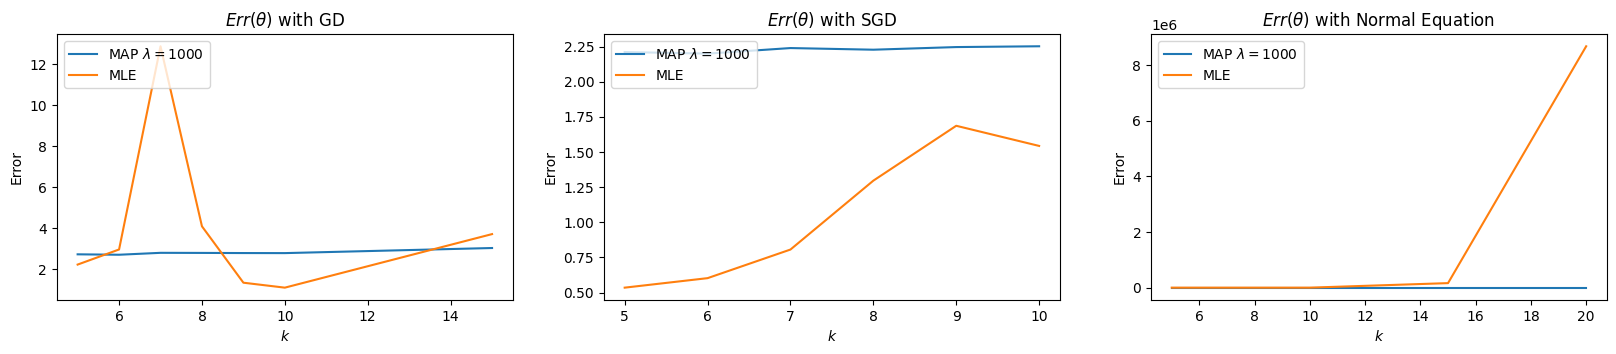

In [31]:
def err(theta, theta_true):
    if theta.shape[0] > theta_true.shape[0]:
        theta_true = np.pad(theta_true, (0,theta.shape[0]-theta_true.shape[0]), 'constant', constant_values=(0,0))
    else:
        theta = np.pad(theta, (0,theta_true.shape[0]-theta.shape[0]), 'constant', constant_values=(0,0))
    return np.linalg.norm(theta-theta_true,2)**2

# Calculating test error for MAP with different lambdas
for j,lam in enumerate(lambdas):
    theta_errors_GD_MAP, theta_errors_SGD_MAP, theta_errors_Normal_MAP = [],[],[]
    for i,k in enumerate(kk_GD_MAP):
        #theta_errors_GD_MAP.append(evaluate(theta=thetas_GD_MAP_lam[j][i], test_set=(X_test, y_test)))
        theta_errors_GD_MAP.append(err(thetas_GD_MAP_lam[j][i], theta_true))

    for i,k in enumerate(kk_SGD_MAP):
        #theta_errors_SGD_MAP.append(evaluate(theta=thetas_SGD_MAP_lam[j][i], test_set=(X_test, y_test)))
        theta_errors_SGD_MAP.append(err(thetas_SGD_MAP_lam[j][i], theta_true))
        
    for i,k in enumerate(kk_Normal_MAP):
        # theta_errors_Normal_MAP.append(evaluate(theta=thetas_Normal_MAP_lam[j][i], test_set=(X_test, y_test)))
        theta_errors_Normal_MAP.append(err(thetas_Normal_MAP_lam[j][i], theta_true))
        
    # Calculating test error for MLE
    theta_errors_GD_MLE, theta_errors_SGD_MLE, theta_errors_Normal_MLE = [],[],[]
    for i,k in enumerate(kk_GD_MLE):
        # theta_errors_GD_MLE.append(evaluate(theta=thetas_GD_MLE[i], test_set=(X_test, y_test)))
        theta_errors_GD_MLE.append(err(thetas_GD_MLE[i], theta_true))
        
    for i,k in enumerate(kk_SGD_MLE):
        #theta_errors_SGD_MLE.append(evaluate(theta=thetas_SGD_MLE[i], test_set=(X_test, y_test)))
        theta_errors_SGD_MLE.append(err(thetas_SGD_MLE[i], theta_true))
        
    for i,k in enumerate(kk_Normal_MLE):
        # theta_errors_Normal_MLE.append(evaluate(theta=thetas_Normal_MLE[i], test_set=(X_test, y_test)))
        theta_errors_Normal_MLE.append(err(thetas_Normal_MLE[i], theta_true))
        
    plot_errors(kk = [kk_GD_MAP, kk_SGD_MAP, kk_Normal_MAP],
                train_errors=[theta_errors_GD_MLE, theta_errors_SGD_MLE, theta_errors_Normal_MLE],
                test_errors=[theta_errors_GD_MAP, theta_errors_SGD_MAP, theta_errors_Normal_MAP],
                title=['$Err(\\theta)$ with GD', '$Err(\\theta)$ with SGD','$Err(\\theta)$ with Normal Equation'],
                labels=['MLE', f'MAP $\\lambda={lam}$'])

**As we can see from all the plots above, it's clear that the using MAP with high values for $\lambda$ helps lowering the test error, and so helps avoiding overfitting.** 